# 付属資料（Rによる経済予測シミュレーション）

### 著者
- 氏名：柴田 怜
- 職業：データサイエンティスト
- 学位：上智大学修士（環境学）

### 前提
1. メモリ容量の最大化
1. 必要なライブラリの読込
1. 関数定義
1. ローデータの目視確認

### 設計
1. 誤差項調整
1. 多重共線性の実証分析
1. 無相関検定
1. 単位根検定(ADF検定)
1. 共和分検定
1. 偏グレンジャー因果性検定と非直交化インパルス応答関数
1. パネルVARモデルによる動的直接相関係数の導出
1. 幾何ブラウン運動
1. LSTM (Long Short Term Memory)
1. グラフ描画・出力

## メモリ容量の最大化

In [1]:
memory.limit(memory.size(max = T))
gc(verbose = getOption("verbose"), reset = T, full = T)

## 必要なライブラリの読込

In [2]:
load.lib <- c(
 "data.table"     #.csv読込・出力
 , "magrittr"     #前処理
 , "tidyr"        #前処理
 , "dplyr"        #前処理
 , "tidyverse"    #前処理
 , "tseries"      #前処理
 , "urca"         #ADF検定
 , "aTSA"         #共和分検定
 , "plm"          #パネルデータの形成
 , "panelvar"     #パネルVARモデル
 , "Sim.DiffProc" #幾何ブラウン運動
 , "ggplot2"      #可視化
 , "gridExtra"    #グラフの集約
 , "qgraph"       #相関行列の可視化
 , "tsbox"        #ts_df関数の利用
 , "keras"        #LSTMによる幾何ブラウン運動の精度評価
 , "tensorflow"   #LSTMによる幾何ブラウン運動の精度評価
 , "vars"         #関数定義に用いる(以下、同じ)。
 , "NlinTS"
 , "tsDyn"
)
install.lib <- load.lib[!load.lib %in% installed.packages()]
for(lib in install.lib) install.packages(lib,dependencies = T)
sapply(load.lib,require,character = T)
#LSTMによる幾何ブラウン運動の精度評価
install_tensorflow(gpu = TRUE) #GPUの利用

 要求されたパッケージ magrittr をロード中です 

 要求されたパッケージ tidyr をロード中です 


 次のパッケージを付け加えます: 'tidyr' 


 以下のオブジェクトは 'package:magrittr' からマスクされています: 

     extract 


 要求されたパッケージ dplyr をロード中です 


 次のパッケージを付け加えます: 'dplyr' 


 以下のオブジェクトは 'package:data.table' からマスクされています: 

     between, first, last 


 以下のオブジェクトは 'package:stats' からマスクされています: 

     filter, lag 


 以下のオブジェクトは 'package:base' からマスクされています: 

     intersect, setdiff, setequal, union 


 要求されたパッケージ tidyverse をロード中です 

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::extract()   masks magrittr::extract()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first

data.table     magrittr        tidyr        dplyr    tidyverse      tseries 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
        urca         aTSA          plm     panelvar Sim.DiffProc      ggplot2 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
   gridExtra       qgraph        tsbox        keras   tensorflow         vars 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
      NlinTS        tsDyn 
        TRUE         TRUE


Installation complete.



## 関数定義
- 対数差分系列
- プロビット写像
- 偏グレンジャー因果性検定と非直交化インパルス応答関数
- ADF検定
- 標本分散
- 時系列プロット
- LSTM (Long Short Term Memory)

In [3]:
#対数差分系列に変換する。
diff.log <- function(x) {
  y <- diff(log(x))
  return(y)
}
#プロビット写像
probit <- function(x) {
  y <- c(exp(((-x^2)/2))/sqrt(2 * pi))
  return(y)
}
#偏グレンジャー因果性検定と非直交化インパルス応答関数
ts <- function(y1, y2) {
  temp  <- cbind(y1, y2) %>% as.data.frame
  model <- VAR(temp, p = 2, type = "both", ic = "AIC")
  wk_result_1  <- causality(model, cause = "y1")
  wk_result_2  <- causality(model, cause = "y2")
  granger      <- list(wk_result_1, wk_result_2)
  impulse_1 <- irf(model, impulse = "y1", response = "y2", boot = F)
  impulse_2 <- irf(model, impulse = "y2", response = "y1", boot = F)
  imp <- list(impulse_1, impulse_2)
  result <- list(granger, imp)
  return(result)
}
#ADF検定
ADF <- function(x) {
  result <- ur.df(x,type = c("drift"), lags = 1) %>%
    summary
  return(result)
}
#標本分散
sigma <- function(x) {
  result <- var(x)*(length(x)-1)/length(x)
  return(result)
}
#時系列プロット
fig <- function(data, y, title, label) {
  data %>%
    ggplot(aes(x = time, y = y)) +
    geom_point() +
    geom_line() +
    ggtitle(title) +
    labs(x = "年", y =  label)
}
#LSTM(Long Short Term Memory)の前処理
#時系列データts_dfをwindowで指定した長さ毎に区切って訓練用のデータを生成する。
LSTM <- function(ts_df, window, rm.na = F) {
  data.x = NULL
  data.y = NULL
  n = dim(ts_df)[2]
  for(i in 1:n){
    ts_x = ts_df[,i]
    for(j in 1:(length(ts_x)-window)){
      if(rm.na){
        tmp.x = ts_x[1:window + j -1]
        tmp.y = ts_x[1:window + j -1]
        if(sum(c(is.na(tmp.x),is.na(tmp.y))) == 0){
          data.x = rbind(data.x,ts_x[1:window + j -1])
          data.y = rbind(data.y,ts_x[window + j])          
        }
      }else{
        data.x = rbind(data.x,ts_x[1:window + j -1])
        data.y = rbind(data.y,ts_x[window + j])
      }
    }
  }
  data <- list(x = array_reshape(data.x,c(dim(data.x),1)),
               y = data.y)
  scale = max(ts_df, na.rm = T)
  x = data$x / scale
  y = data$y / scale
  lstm <- keras_model_sequential()
  lstm %>%
    layer_lstm(units = 64,input_shape = c(dim(x)[2],1)) %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 1)
  lstm %>% compile(loss = "mean_squared_error",
                   optimizer = optimizer_adam(),
                   metrics = "accuracy")
  lstm %>% fit(x,y,
               epochs = 1000,batch_size = 10, validation_split = 0.2)
  i = 1
  test_x = ts_df[,i]
  test_x = data$x
  scale=max(ts_df,na.rm = T)
  test_x = test_x/scale
  pred_x = lstm %>% 
    predict(test_x)  
  ts.plot(ts_df[,i]/scale->a,ylim = c(min(c(a,pred_x)), max(c(a,pred_x))), ylab = "検証値")
  lines(c(rep(NA,window),pred_x), col = 2)
}

# ローデータの目視確認
- 読込
- 要約統計量を求める。

In [4]:
#読込
raw_data <- fread("./0_input/raw_data.csv") %>%
  as.data.frame
raw_data

id,time,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11
<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,1986,11.36838,1111250,0,20.90,1.212152e-313,42.4,85.9,2.6,217.71013,58.594,0
0,1987,11.91077,1111019,0,24.12,1.437787e-313,41.9,85.9,2.8,251.03609,58.594,0
0,1988,12.58026,1186750,0,18.37,1.734345e-313,40.4,86.5,2.8,348.65896,58.594,0
0,1989,13.02217,1216857,0,22.40,1.735299e-313,38.7,88.5,2.5,439.72734,58.594,0
0,1990,13.54005,1304676,0,27.67,1.772752e-313,36.8,91.2,2.3,261.49901,53.711,0
0,1991,13.73636,1318934,1,23.65,1.974477e-313,36.2,94.3,2.1,243.73033,53.711,0
0,1992,13.85659,1330643,0,22.79,2.087208e-313,36.9,95.8,2.1,176.66962,43.640,1
0,1993,14.00667,1333073,0,19.51,2.313130e-313,39.9,97.1,2.2,179.37425,43.640,0
0,1994,14.50500,1385835,0,18.97,2.530688e-313,41.1,97.7,2.5,201.87369,43.640,1


In [5]:
# 要約統計量を求める。
raw_data %>%
  summary

       id              time            Y1              Y2         
 Min.   :0.0000   Min.   :1986   Min.   :11.37   Min.   :1111019  
 1st Qu.:0.0000   1st Qu.:1993   1st Qu.:13.86   1st Qu.:1315869  
 Median :0.0000   Median :2000   Median :14.51   Median :1385835  
 Mean   :0.1379   Mean   :2000   Mean   :14.44   Mean   :1352237  
 3rd Qu.:0.0000   3rd Qu.:2007   3rd Qu.:15.46   3rd Qu.:1422453  
 Max.   :1.0000   Max.   :2014   Max.   :15.74   Max.   :1478859  
       Y3               Y4              Y5                   Y6        
 Min.   :0.0000   Min.   :15.90   Min.   :1.212e-313   Min.   : 36.20  
 1st Qu.:0.0000   1st Qu.:22.40   1st Qu.:2.052e-313   1st Qu.: 41.90  
 Median :0.0000   Median :31.80   Median :2.303e-313   Median : 69.50  
 Mean   :0.2069   Mean   :44.78   Mean   :2.288e-313   Mean   : 77.77  
 3rd Qu.:0.0000   3rd Qu.:71.49   3rd Qu.:2.531e-313   3rd Qu.:102.00  
 Max.   :1.0000   Max.   :95.30   Max.   :3.176e-313   Max.   :149.50  
       Y7               Y8 

## 誤差項調整
- 対数差分系列(一次のテイラー展開近似によって変化率に近似するとともに、定常状態として扱う為)
- プロビット写像(Y3: 原子力事故・異常事象(有無)及びY11: 気候変動対策に関する合意(有無))

In [6]:
adjusted <- bind_cols(
    raw_data$id[-1]
    , time = raw_data$time[-1]
    , Y1   = diff.log(raw_data$Y1)
    , Y2   = diff.log(raw_data$Y2)
    , Y3   = probit(raw_data$Y3) %>% diff.log
    , Y4   = diff.log(raw_data$Y4)
    , Y5   = diff.log(raw_data$Y5)
    , Y6   = diff.log(raw_data$Y6)
    , Y7   = diff.log(raw_data$Y7)
    , Y8   = diff.log(raw_data$Y8)
    , Y9   = diff.log(raw_data$Y9)
    , Y10  = diff.log(raw_data$Y10)
    , Y11  = probit(raw_data$Y11) %>% diff.log
) %>%
  as.data.frame %>%
  apply(2, as.numeric)
#列名を戻す。
colnames(adjusted) <- colnames(raw_data)
#目視確認
adjusted

New names:
* `` -> ...1



id,time,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11
0,1987,0.046607215,-0.0002078956,0.0,0.14329221,0.1707078336,-0.011862535,0.000000000,0.07410797,0.142432215,0.0000000000,0.0
0,1988,0.054685886,0.0659408662,0.0,-0.27232247,0.1875246945,-0.036456042,0.006960585,0.00000000,0.328497539,0.0000000000,0.0
0,1989,0.034524371,0.0250528266,0.0,0.19834206,0.0005499123,-0.042990185,0.022858138,-0.11332869,0.232060601,0.0000000000,0.0
0,1990,0.038998671,0.0696834290,0.0,0.21128783,0.0213534086,-0.050341755,0.030052345,-0.08338161,-0.519724355,-0.0870144800,0.0
0,1991,0.014394372,0.0108691005,-0.5,-0.15698568,0.1077704117,-0.016438726,0.033426293,-0.09097178,-0.070368088,0.0000000000,0.0
0,1992,0.008714600,0.0088384495,0.5,-0.03704127,0.0555237346,0.019152432,0.015781495,0.00000000,-0.321780974,-0.2076436613,-0.5
0,1993,0.010772713,0.0018245193,0.0,-0.15539469,0.1027742980,0.078164773,0.013478690,0.04652002,0.015192971,0.0000000000,0.5
0,1994,0.034959773,0.0388160427,0.0,-0.02806837,0.0898896168,0.029631798,0.006160184,0.12783337,0.118167799,0.0000000000,-0.5
0,1995,0.031159245,0.0255089921,-0.5,-0.01487016,0.0913040437,0.059049029,-0.001024066,0.14842001,0.008353525,0.0000000000,0.5
0,1996,0.015857216,0.0017373256,0.5,0.19217123,-0.1259988250,0.060084811,0.001024066,0.09844007,-0.026863215,0.0868586003,0.0


## 多重共線性の実証分析

In [7]:
#確率変数のみのデータフレーム
relation <- adjusted[, !(colnames(adjusted) %in% c("id", "time"))] %>%
  apply(2, as.numeric) %>%
  as.data.frame
#目視確認
relation

Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.046607215,-0.0002078956,0.0,0.14329221,0.1707078336,-0.011862535,0.000000000,0.07410797,0.142432215,0.0000000000,0.0
0.054685886,0.0659408662,0.0,-0.27232247,0.1875246945,-0.036456042,0.006960585,0.00000000,0.328497539,0.0000000000,0.0
0.034524371,0.0250528266,0.0,0.19834206,0.0005499123,-0.042990185,0.022858138,-0.11332869,0.232060601,0.0000000000,0.0
0.038998671,0.0696834290,0.0,0.21128783,0.0213534086,-0.050341755,0.030052345,-0.08338161,-0.519724355,-0.0870144800,0.0
0.014394372,0.0108691005,-0.5,-0.15698568,0.1077704117,-0.016438726,0.033426293,-0.09097178,-0.070368088,0.0000000000,0.0
0.008714600,0.0088384495,0.5,-0.03704127,0.0555237346,0.019152432,0.015781495,0.00000000,-0.321780974,-0.2076436613,-0.5
0.010772713,0.0018245193,0.0,-0.15539469,0.1027742980,0.078164773,0.013478690,0.04652002,0.015192971,0.0000000000,0.5
0.034959773,0.0388160427,0.0,-0.02806837,0.0898896168,0.029631798,0.006160184,0.12783337,0.118167799,0.0000000000,-0.5
0.031159245,0.0255089921,-0.5,-0.01487016,0.0913040437,0.059049029,-0.001024066,0.14842001,0.008353525,0.0000000000,0.5


## 無相関検定
- 相関係数に統計的有意性を検出すれば、多重共線性がある。

In [8]:
#Y1～11
cor.test(relation$Y1, relation$Y2,   method = "pearson")
cor.test(relation$Y1, relation$Y3,   method = "pearson")
cor.test(relation$Y1, relation$Y4,   method = "pearson") 
cor.test(relation$Y1, relation$Y5,   method = "pearson")  
cor.test(relation$Y1, relation$Y6,   method = "pearson")  
cor.test(relation$Y1, relation$Y7,   method = "pearson")  
cor.test(relation$Y1, relation$Y8,   method = "pearson")  
cor.test(relation$Y1, relation$Y9,   method = "pearson")  
cor.test(relation$Y1, relation$Y10,  method = "pearson")  
cor.test(relation$Y1, relation$Y11,  method = "pearson") 
#Y2～11
cor.test(relation$Y2, relation$Y3,   method = "pearson")  
cor.test(relation$Y2, relation$Y4,   method = "pearson")  
cor.test(relation$Y2, relation$Y5,   method = "pearson")  
cor.test(relation$Y2, relation$Y6,   method = "pearson")  
cor.test(relation$Y2, relation$Y7,   method = "pearson")  
cor.test(relation$Y2, relation$Y8,   method = "pearson")  
cor.test(relation$Y2, relation$Y9,   method = "pearson")  
cor.test(relation$Y2, relation$Y10,  method = "pearson")  
cor.test(relation$Y2, relation$Y11,  method = "pearson")
#Y3～11
cor.test(relation$Y3, relation$Y4,   method = "pearson")  
cor.test(relation$Y3, relation$Y5,   method = "pearson")  
cor.test(relation$Y3, relation$Y6,   method = "pearson")  
cor.test(relation$Y3, relation$Y7,   method = "pearson")  
cor.test(relation$Y3, relation$Y8,   method = "pearson")  
cor.test(relation$Y3, relation$Y9,   method = "pearson")  
cor.test(relation$Y3, relation$Y10,  method = "pearson")  
cor.test(relation$Y3, relation$Y11,  method = "pearson")
#Y4～11
cor.test(relation$Y4, relation$Y5,   method = "pearson")  
cor.test(relation$Y4, relation$Y6,   method = "pearson")  
cor.test(relation$Y4, relation$Y7,   method = "pearson")  
cor.test(relation$Y4, relation$Y8,   method = "pearson")  
cor.test(relation$Y4, relation$Y9,   method = "pearson")  
cor.test(relation$Y4, relation$Y10,  method = "pearson")  
cor.test(relation$Y4, relation$Y11,  method = "pearson")
#Y5～11
cor.test(relation$Y5, relation$Y6,   method = "pearson")  
cor.test(relation$Y5, relation$Y7,   method = "pearson")  
cor.test(relation$Y5, relation$Y8,   method = "pearson")  
cor.test(relation$Y5, relation$Y9,   method = "pearson")  
cor.test(relation$Y5, relation$Y10,  method = "pearson")  
cor.test(relation$Y5, relation$Y11,  method = "pearson")
#Y6～11
cor.test(relation$Y6, relation$Y7,   method = "pearson")  
cor.test(relation$Y6, relation$Y8,   method = "pearson")  
cor.test(relation$Y6, relation$Y9,   method = "pearson")  
cor.test(relation$Y6, relation$Y10,  method = "pearson")  
cor.test(relation$Y6, relation$Y11,  method = "pearson")
#Y7～11
cor.test(relation$Y7, relation$Y8,   method = "pearson")  
cor.test(relation$Y7, relation$Y9,   method = "pearson")  
cor.test(relation$Y7, relation$Y10,  method = "pearson")  
cor.test(relation$Y7, relation$Y11,  method = "pearson")
#Y8～11
cor.test(relation$Y8, relation$Y9,   method = "pearson")  
cor.test(relation$Y8, relation$Y10,  method = "pearson")  
cor.test(relation$Y8, relation$Y11,  method = "pearson")
#Y9～11
cor.test(relation$Y9, relation$Y10,  method = "pearson")  
cor.test(relation$Y9, relation$Y11,  method = "pearson")
#Y10～11
cor.test(relation$Y10,relation$Y11,  method = "pearson")


	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y2
t = 3.5192, df = 26, p-value = 0.001615
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2473684 0.7765392
sample estimates:
      cor 
0.5680239 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y3
t = -0.82961, df = 26, p-value = 0.4143
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5034989  0.2260314
sample estimates:
       cor 
-0.1605874 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y4
t = 0.37222, df = 26, p-value = 0.7127
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3086556  0.4340912
sample estimates:
       cor 
0.07280495 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y5
t = 1.6873, df = 26, p-value = 0.1035
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.06675539  0.61512889
sample estimates:
      cor 
0.3141453 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y6
t = -2.0161, df = 26, p-value = 0.05423
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.651411333  0.006239047
sample estimates:
       cor 
-0.3676937 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y7
t = 0.22034, df = 26, p-value = 0.8273
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3353049  0.4096515
sample estimates:
       cor 
0.04317269 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y8
t = 2.2233, df = 26, p-value = 0.0351
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03126576 0.67248257
sample estimates:
      cor 
0.3996806 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y9
t = 1.4284, df = 26, p-value = 0.1651
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1148885  0.5840500
sample estimates:
      cor 
0.2697505 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y10
t = 0.013351, df = 26, p-value = 0.9894
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3708209  0.3753286
sample estimates:
        cor 
0.002618298 



	Pearson's product-moment correlation

data:  relation$Y1 and relation$Y11
t = -0.48014, df = 26, p-value = 0.6351
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4510497  0.2894523
sample estimates:
        cor 
-0.09374834 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y3
t = -0.5077, df = 26, p-value = 0.6159
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4553247  0.2845153
sample estimates:
        cor 
-0.09907837 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y4
t = 1.1858, df = 26, p-value = 0.2464
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1600924  0.5528691
sample estimates:
      cor 
0.2265135 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y5
t = 2.7097, df = 26, p-value = 0.01176
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1166096 0.7168467
sample estimates:
      cor 
0.4692712 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y6
t = -1.7912, df = 26, p-value = 0.08491
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.62698322  0.04752009
sample estimates:
       cor 
-0.3314327 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y7
t = 0.35592, df = 26, p-value = 0.7248
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3115373  0.4315001
sample estimates:
       cor 
0.06963285 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y8
t = 0.86746, df = 26, p-value = 0.3936
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2190701  0.5089462
sample estimates:
      cor 
0.1677141 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y9
t = -0.56028, df = 26, p-value = 0.5801
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4634164  0.2750623
sample estimates:
      cor 
-0.109223 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y10
t = 2.2109, df = 26, p-value = 0.03604
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02904425 0.67126277
sample estimates:
      cor 
0.3978106 



	Pearson's product-moment correlation

data:  relation$Y2 and relation$Y11
t = -1.2436, df = 26, p-value = 0.2247
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5604747  0.1493354
sample estimates:
       cor 
-0.2369425 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y4
t = 1.2923, df = 26, p-value = 0.2076
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1402566  0.5668019
sample estimates:
      cor 
0.2456757 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y5
t = -0.66727, df = 26, p-value = 0.5105
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4796156  0.2556986
sample estimates:
       cor 
-0.1297565 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y6
t = -0.029419, df = 26, p-value = 0.9768
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3780327  0.3680998
sample estimates:
         cor 
-0.005769442 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y7
t = -0.21864, df = 26, p-value = 0.8286
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4093734  0.3356014
sample estimates:
        cor 
-0.04283918 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y8
t = -0.08408, df = 26, p-value = 0.9336
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3871826  0.3587967
sample estimates:
        cor 
-0.01648723 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y9
t = -1.1614, df = 26, p-value = 0.256
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5496236  0.1646318
sample estimates:
       cor 
-0.2220857 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y10
t = 0.13456, df = 26, p-value = 0.894
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3501430  0.3955639
sample estimates:
       cor 
0.02637999 



	Pearson's product-moment correlation

data:  relation$Y3 and relation$Y11
t = -1.6543, df = 26, p-value = 0.1101
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.61130196  0.07285875
sample estimates:
       cor 
-0.3086067 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y5
t = 0.49024, df = 26, p-value = 0.6281
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2876439  0.4526195
sample estimates:
       cor 
0.09570321 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y6
t = -0.43891, df = 26, p-value = 0.6644
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4446117  0.2968133
sample estimates:
        cor 
-0.08576023 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y7
t = -0.59158, df = 26, p-value = 0.5592
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4681922  0.2694151
sample estimates:
       cor 
-0.1152454 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y8
t = 0.79834, df = 26, p-value = 0.4319
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2317682  0.4989660
sample estimates:
      cor 
0.1546839 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y9
t = -0.64895, df = 26, p-value = 0.5221
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4768670  0.2590262
sample estimates:
       cor 
-0.1262512 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y10
t = 1.7486, df = 26, p-value = 0.09216
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05539499  0.62216755
sample estimates:
      cor 
0.3243859 



	Pearson's product-moment correlation

data:  relation$Y4 and relation$Y11
t = -1.8238, df = 26, p-value = 0.0797
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.63062382  0.04151056
sample estimates:
      cor 
-0.336782 



	Pearson's product-moment correlation

data:  relation$Y5 and relation$Y6
t = -0.83025, df = 26, p-value = 0.414
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5035916  0.2259136
sample estimates:
       cor 
-0.1607083 



	Pearson's product-moment correlation

data:  relation$Y5 and relation$Y7
t = 0.048602, df = 26, p-value = 0.9616
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3648430  0.3812525
sample estimates:
        cor 
0.009531276 



	Pearson's product-moment correlation

data:  relation$Y5 and relation$Y8
t = 1.4276, df = 26, p-value = 0.1653
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1150430  0.5839468
sample estimates:
      cor 
0.2696053 



	Pearson's product-moment correlation

data:  relation$Y5 and relation$Y9
t = 0.1897, df = 26, p-value = 0.851
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3406234  0.4046425
sample estimates:
       cor 
0.03717803 



	Pearson's product-moment correlation

data:  relation$Y5 and relation$Y10
t = -0.36764, df = 26, p-value = 0.7161
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4333642  0.3094655
sample estimates:
        cor 
-0.07191429 



	Pearson's product-moment correlation

data:  relation$Y5 and relation$Y11
t = -0.3284, df = 26, p-value = 0.7452
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4271069  0.3163922
sample estimates:
        cor 
-0.06427117 



	Pearson's product-moment correlation

data:  relation$Y6 and relation$Y7
t = -3.9711, df = 26, p-value = 0.0005041
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.8033582 -0.3131423
sample estimates:
       cor 
-0.6144369 



	Pearson's product-moment correlation

data:  relation$Y6 and relation$Y8
t = 2.5973, df = 26, p-value = 0.01526
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09727328 0.70720369
sample estimates:
      cor 
0.4538788 



	Pearson's product-moment correlation

data:  relation$Y6 and relation$Y9
t = -0.0060965, df = 26, p-value = 0.9952
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3741057  0.3720473
sample estimates:
         cor 
-0.001195629 



	Pearson's product-moment correlation

data:  relation$Y6 and relation$Y10
t = -0.70264, df = 26, p-value = 0.4885
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4848906  0.2492632
sample estimates:
       cor 
-0.1365082 



	Pearson's product-moment correlation

data:  relation$Y6 and relation$Y11
t = 1.0574, df = 26, p-value = 0.3001
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1839615  0.5355576
sample estimates:
      cor 
0.2030512 



	Pearson's product-moment correlation

data:  relation$Y7 and relation$Y8
t = -2.7066, df = 26, p-value = 0.01185
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7165831 -0.1160749
sample estimates:
       cor 
-0.4688484 



	Pearson's product-moment correlation

data:  relation$Y7 and relation$Y9
t = -1.3994, df = 26, p-value = 0.1735
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5804276  0.1202929
sample estimates:
       cor 
-0.2646616 



	Pearson's product-moment correlation

data:  relation$Y7 and relation$Y10
t = 0.32645, df = 26, p-value = 0.7467
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3167360  0.4267945
sample estimates:
       cor 
0.06389073 



	Pearson's product-moment correlation

data:  relation$Y7 and relation$Y11
t = -0.28724, df = 26, p-value = 0.7762
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4204961  0.3236252
sample estimates:
        cor 
-0.05624227 



	Pearson's product-moment correlation

data:  relation$Y8 and relation$Y9
t = -0.058966, df = 26, p-value = 0.9534
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3829881  0.3630799
sample estimates:
        cor 
-0.01156338 



	Pearson's product-moment correlation

data:  relation$Y8 and relation$Y10
t = -0.96936, df = 26, p-value = 0.3413
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5233726  0.2002684
sample estimates:
       cor 
-0.1867626 



	Pearson's product-moment correlation

data:  relation$Y8 and relation$Y11
t = -0.20713, df = 26, p-value = 0.8375
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4074949  0.3376005
sample estimates:
        cor 
-0.04058856 



	Pearson's product-moment correlation

data:  relation$Y9 and relation$Y10
t = 0.58027, df = 26, p-value = 0.5667
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2714573  0.4664701
sample estimates:
      cor 
0.1130708 



	Pearson's product-moment correlation

data:  relation$Y9 and relation$Y11
t = 0.53731, df = 26, p-value = 0.5956
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2791975  0.4598918
sample estimates:
      cor 
0.1047951 



	Pearson's product-moment correlation

data:  relation$Y10 and relation$Y11
t = -2.0247, df = 26, p-value = 0.05328
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.652309740  0.004676858
sample estimates:
      cor 
-0.369044 


# 多変量時系列分析
- 単位根検定(ADF検定)
- 共和分検定
- 偏グレンジャー因果性検定と非直交化インパルス応答関数
- パネルVARモデルによる動的直接相関係数の導出
- 幾何ブラウン運動と確率偏微分方程式
- LSTM(Long Short Term Memory)

## 単位根検定(ADF検定)

In [9]:
relation %>%
  apply(2, ADF)

$Y1

############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.06802 -0.01276  0.00237  0.01493  0.05123 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.0004843  0.0052101   0.093  0.92674   
z.lag.1     -0.6311647  0.2209387  -2.857  0.00892 **
z.diff.lag  -0.0450070  0.1992158  -0.226  0.82326   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02523 on 23 degrees of freedom
Multiple R-squared:  0.3465,	Adjusted R-squared:  0.2897 
F-statistic: 6.098 on 2 and 23 DF,  p-value: 0.0075


Value of test-statistic is: -2.8567 4.4176 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.58 -2.93 -2.60
phi1  7.06  4.86  3.94


$Y2

####################################

## 共和分検定

In [10]:
#Y1～11
coint.test(relation$Y1, relation$Y2,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y3,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y4,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y5,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y6,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y7,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y1, relation$Y11, nlag = 1) %>% summary
#Y2～11
coint.test(relation$Y2, relation$Y3,  nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y4,  nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y6,  nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y7,  nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y2, relation$Y11, nlag = 1) %>% summary
#Y3～11
coint.test(relation$Y3, relation$Y4,  nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y5,  nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y6,  nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y7,  nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y3, relation$Y11, nlag = 1) %>% summary
#Y4～11
coint.test(relation$Y4, relation$Y5,  nlag = 1) %>% summary
coint.test(relation$Y4, relation$Y6,  nlag = 1) %>% summary
coint.test(relation$Y4, relation$Y7,  nlag = 1) %>% summary
coint.test(relation$Y4, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y4, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y4, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y4, relation$Y11, nlag = 1) %>% summary
#Y5～11
coint.test(relation$Y5, relation$Y6,  nlag = 1) %>% summary
coint.test(relation$Y5, relation$Y7,  nlag = 1) %>% summary
coint.test(relation$Y5, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y5, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y5, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y5, relation$Y11, nlag = 1) %>% summary
#Y6～11
coint.test(relation$Y6, relation$Y7,  nlag = 1) %>% summary
coint.test(relation$Y6, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y6, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y6, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y6, relation$Y11, nlag = 1) %>% summary
#Y7～11
coint.test(relation$Y7, relation$Y8,  nlag = 1) %>% summary
coint.test(relation$Y7, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y7, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y7, relation$Y11, nlag = 1) %>% summary
#Y8～11
coint.test(relation$Y8, relation$Y9,  nlag = 1) %>% summary
coint.test(relation$Y8, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y8, relation$Y11, nlag = 1) %>% summary
#Y9～11
coint.test(relation$Y9, relation$Y10, nlag = 1) %>% summary
coint.test(relation$Y9, relation$Y11, nlag = 1) %>% summary
#Y10～11
coint.test(relation$Y10, relation$Y11, nlag = 1) %>% summary

Response: relation$Y1 
Input: relation$Y2 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.55    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.44    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.826   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-4.5544   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.9967   1st Qu.:0.055  
 Median :1   Median :-1.4389   Median :0.100  
 Mean   :1   Mean   :-1.7225   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.3065   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.8259   Max.   :0.100  

Response: relation$Y1 
Input: relation$Y3 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.3169  0.0308 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.54    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.04    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.3169   Min.   :0.03076  
 1st Qu.:1   1st Qu.:-2.4277   1st Qu.:0.06538  
 Median :1   Median :-1.5385   Median :0.10000  
 Mean   :1   Mean   :-1.2721   Mean   :0.07692  
 3rd Qu.:1   3rd Qu.:-0.2497   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.0391   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y4 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.2421  0.0349 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.52    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.974   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.2421   Min.   :0.03493  
 1st Qu.:1   1st Qu.:-2.3821   1st Qu.:0.06747  
 Median :1   Median :-1.5221   Median :0.10000  
 Mean   :1   Mean   :-1.2635   Mean   :0.07831  
 3rd Qu.:1   3rd Qu.:-0.2742   3rd Qu.:0.10000  
 Max.   :1   Max.   : 0.9737   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y5 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.6274  0.0134 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.36    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.04    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.6274   Min.   :0.01344  
 1st Qu.:1   1st Qu.:-2.4913   1st Qu.:0.05672  
 Median :1   Median :-1.3552   Median :0.10000  
 Mean   :1   Mean   :-1.3128   Mean   :0.07115  
 3rd Qu.:1   3rd Qu.:-0.1555   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.0442   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y6 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.3000  0.0317 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.34    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.71    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.3000   Min.   :0.03170  
 1st Qu.:1   1st Qu.:-2.3197   1st Qu.:0.06585  
 Median :1   Median :-1.3394   Median :0.10000  
 Mean   :1   Mean   :-0.9764   Mean   :0.07723  
 3rd Qu.:1   3rd Qu.: 0.1854   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.7101   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y7 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.3616  0.0283 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.52    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.07    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.3616   Min.   :0.02826  
 1st Qu.:1   1st Qu.:-2.4391   1st Qu.:0.06413  
 Median :1   Median :-1.5166   Median :0.10000  
 Mean   :1   Mean   :-1.2683   Mean   :0.07609  
 3rd Qu.:1   3rd Qu.:-0.2216   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.0733   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -2.7384  0.0837 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.33    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.282   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-2.7384   Min.   :0.08369  
 1st Qu.:1   1st Qu.:-2.0361   1st Qu.:0.09184  
 Median :1   Median :-1.3337   Median :0.10000  
 Mean   :1   Mean   :-1.2634   Mean   :0.09456  
 3rd Qu.:1   3rd Qu.:-0.5258   3rd Qu.:0.10000  
 Max.   :1   Max.   : 0.2820   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.1780  0.0385 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.63    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.48    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value       
 Min.   :1   Min.   :-3.17803   Min.   :0.03850  
 1st Qu.:1   1st Qu.:-2.40490   1st Qu.:0.06925  
 Median :1   Median :-1.63176   Median :0.10000  
 Mean   :1   Mean   :-1.11147   Mean   :0.07950  
 3rd Qu.:1   3rd Qu.:-0.07819   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.47539   Max.   :0.10000  

Response: relation$Y1 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.2911  0.0322 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.52    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.02    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value      
 Min.   :1   Min.   :-3.2911   Min.   :0.0322  
 1st Qu.:1   1st Qu.:-2.4068   1st Qu.:0.0661  
 Median :1   Median :-1.5225   Median :0.1000  
 Mean   :1   Mean   :-1.2640   Mean   :0.0774  
 3rd Qu.:1   3rd Qu.:-0.2504   3rd Qu.:0.1000  
 Max.   :1   Max.   : 1.0217   Max.   :0.1000  

Response: relation$Y1 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.2519  0.0344 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.48    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.954   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.2519   Min.   :0.03438  
 1st Qu.:1   1st Qu.:-2.3684   1st Qu.:0.06719  
 Median :1   Median :-1.4849   Median :0.10000  
 Mean   :1   Mean   :-1.2609   Mean   :0.07813  
 3rd Qu.:1   3rd Qu.:-0.2654   3rd Qu.:0.10000  
 Max.   :1   Max.   : 0.9540   Max.   :0.10000  

Response: relation$Y2 
Input: relation$Y3 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.65    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.04    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.01    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-4.64596   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.84129   1st Qu.:0.055  
 Median :1   Median :-1.03662   Median :0.100  
 Mean   :1   Mean   :-1.55778   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.01369   3rd Qu.:0.100  
 Max.   :1   Max.   : 1.00924   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y4 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.60    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.12    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.952   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-4.60105   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.86161   1st Qu.:0.055  
 Median :1   Median :-1.12217   Median :0.100  
 Mean   :1   Mean   :-1.59034   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.08498   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.95220   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y6 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.72    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.775   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
    1.0     1.6     0.1 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-4.7159   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.7456   1st Qu.:0.055  
 Median :1   Median :-0.7754   Median :0.100  
 Mean   :1   Mean   :-1.2983   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.4105   3rd Qu.:0.100  
 Max.   :1   Max.   : 1.5963   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y7 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.58    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.969   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.02    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-4.57641   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.77293   1st Qu.:0.055  
 Median :1   Median :-0.96945   Median :0.100  
 Mean   :1   Mean   :-1.50750   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.02696   3rd Qu.:0.100  
 Max.   :1   Max.   : 1.02337   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.48    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.965   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.699   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-4.4775   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.7210   1st Qu.:0.055  
 Median :1   Median :-0.9645   Median :0.100  
 Mean   :1   Mean   :-1.5812   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.1330   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.6985   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.51    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.999   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.848   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-4.50577   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.75255   1st Qu.:0.055  
 Median :1   Median :-0.99932   Median :0.100  
 Mean   :1   Mean   :-1.55238   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.07568   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.84796   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -3.88    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -1.13    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
    1.0     1.2     0.1 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-3.88207   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.50522   1st Qu.:0.055  
 Median :1   Median :-1.12836   Median :0.100  
 Mean   :1   Mean   :-1.27100   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.03454   3rd Qu.:0.100  
 Max.   :1   Max.   : 1.19745   Max.   :0.100  

Response: relation$Y2 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.34    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.977   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.881   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-4.34443   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.66085   1st Qu.:0.055  
 Median :1   Median :-0.97727   Median :0.100  
 Mean   :1   Mean   :-1.48012   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.04797   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.88133   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y4 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -8.77    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
 1.0000  0.0447  0.1000 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.264   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-8.77391   Min.   :0.010  
 1st Qu.:1   1st Qu.:-4.51906   1st Qu.:0.055  
 Median :1   Median :-0.26422   Median :0.100  
 Mean   :1   Mean   :-2.99782   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.10977   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.04467   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y5 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.95    0.01 
----- 
 Type 2: linear trend 
     lag       EG  p.value 
 1.00000 -0.00191  0.10000 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.107   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG               p.value     
 Min.   :1   Min.   :-9.946011   Min.   :0.010  
 1st Qu.:1   1st Qu.:-5.026447   1st Qu.:0.055  
 Median :1   Median :-0.106884   Median :0.100  
 Mean   :1   Mean   :-3.351600   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.054395   3rd Qu.:0.100  
 Max.   :1   Max.   :-0.001905   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y6 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.93    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.215   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.161   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-9.92875   Min.   :0.010  
 1st Qu.:1   1st Qu.:-5.04467   1st Qu.:0.055  
 Median :1   Median :-0.16060   Median :0.100  
 Mean   :1   Mean   :-3.29161   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.02695   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.21451   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y7 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.99    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.103   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.177   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-9.98558   Min.   :0.010  
 1st Qu.:1   1st Qu.:-5.08111   1st Qu.:0.055  
 Median :1   Median :-0.17664   Median :0.100  
 Mean   :1   Mean   :-3.35304   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.03677   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.10311   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.94    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.195   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.127   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-9.94315   Min.   :0.010  
 1st Qu.:1   1st Qu.:-5.03483   1st Qu.:0.055  
 Median :1   Median :-0.12651   Median :0.100  
 Mean   :1   Mean   :-3.29150   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.03433   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.19517   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.23    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.286   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.621   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-9.2342   Min.   :0.010  
 1st Qu.:1   1st Qu.:-4.9275   1st Qu.:0.055  
 Median :1   Median :-0.6207   Median :0.100  
 Mean   :1   Mean   :-3.1898   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.1676   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.2855   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.86    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.188   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.143   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-9.86300   Min.   :0.010  
 1st Qu.:1   1st Qu.:-5.00297   1st Qu.:0.055  
 Median :1   Median :-0.14294   Median :0.100  
 Mean   :1   Mean   :-3.27278   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.02233   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.18760   Max.   :0.100  

Response: relation$Y3 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -9.91    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00    0.19    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.265   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value     
 Min.   :1   Min.   :-9.91151   Min.   :0.010  
 1st Qu.:1   1st Qu.:-5.08808   1st Qu.:0.055  
 Median :1   Median :-0.26466   Median :0.100  
 Mean   :1   Mean   :-3.32879   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.03744   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.18979   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y5 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -5.67    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.411   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.332   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-5.6652   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.6668   1st Qu.:0.055  
 Median :1   Median : 0.3317   Median :0.100  
 Mean   :1   Mean   :-1.6409   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.3713   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.4109   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y6 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -5.56    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.401   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    0.47    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-5.5603   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.5794   1st Qu.:0.055  
 Median :1   Median : 0.4015   Median :0.100  
 Mean   :1   Mean   :-1.5630   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.4357   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.4699   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y7 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -6.05    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.196   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.331   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-6.0521   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.9281   1st Qu.:0.055  
 Median :1   Median : 0.1959   Median :0.100  
 Mean   :1   Mean   :-1.8417   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.2635   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.3311   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -5.44    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.353   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.109   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-5.4426   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.6669   1st Qu.:0.055  
 Median :1   Median : 0.1088   Median :0.100  
 Mean   :1   Mean   :-1.6601   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.2311   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.3535   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -5.55    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.339   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.208   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-5.5530   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.6727   1st Qu.:0.055  
 Median :1   Median : 0.2077   Median :0.100  
 Mean   :1   Mean   :-1.6687   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.2734   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.3391   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -5.67    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.226   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.581   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-5.6703   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.7221   1st Qu.:0.055  
 Median :1   Median : 0.2262   Median :0.100  
 Mean   :1   Mean   :-1.6211   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.4035   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.5808   Max.   :0.100  

Response: relation$Y4 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -5.17    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.329   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.268   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-5.1739   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.4531   1st Qu.:0.055  
 Median :1   Median : 0.2678   Median :0.100  
 Mean   :1   Mean   :-1.5256   Mean   :0.070  
 3rd Qu.:1   3rd Qu.: 0.2985   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.3293   Max.   :0.100  

Response: relation$Y5 
Input: relation$Y6 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -3.78    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.705   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.388   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-3.7776   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.2413   1st Qu.:0.055  
 Median :1   Median :-0.7051   Median :0.100  
 Mean   :1   Mean   :-1.3650   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.1587   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.3877   Max.   :0.100  

Response: relation$Y5 
Input: relation$Y7 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -3.72    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.806   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.205   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-3.7180   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.2621   1st Qu.:0.055  
 Median :1   Median :-0.8062   Median :0.100  
 Mean   :1   Mean   :-1.4397   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.3006   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.2051   Max.   :0.100  

Response: relation$Y5 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
  1.000  -3.528   0.019 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -0.71    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.133   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.5283   Min.   :0.01896  
 1st Qu.:1   1st Qu.:-2.1192   1st Qu.:0.05948  
 Median :1   Median :-0.7101   Median :0.10000  
 Mean   :1   Mean   :-1.4571   Mean   :0.07299  
 3rd Qu.:1   3rd Qu.:-0.4215   3rd Qu.:0.10000  
 Max.   :1   Max.   :-0.1329   Max.   :0.10000  

Response: relation$Y5 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -3.73    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00   -0.82    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.232   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-3.7271   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.2737   1st Qu.:0.055  
 Median :1   Median :-0.8204   Median :0.100  
 Mean   :1   Mean   :-1.4386   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.2944   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.2316   Max.   :0.100  

Response: relation$Y5 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -3.85    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.811   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.179   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-3.8541   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.3325   1st Qu.:0.055  
 Median :1   Median :-0.8109   Median :0.100  
 Mean   :1   Mean   :-1.4953   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.3158   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.1792   Max.   :0.100  

Response: relation$Y5 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -3.76    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.799   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.176   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-3.7604   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.2798   1st Qu.:0.055  
 Median :1   Median :-0.7992   Median :0.100  
 Mean   :1   Mean   :-1.4611   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.3114   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.1765   Max.   :0.100  

Response: relation$Y6 
Input: relation$Y7 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.0426  0.0461 
----- 
 Type 2: linear trend 
    lag      EG p.value 
   1.00    0.44    0.10 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.716   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.0426   Min.   :0.04606  
 1st Qu.:1   1st Qu.:-1.3014   1st Qu.:0.07303  
 Median :1   Median : 0.4398   Median :0.10000  
 Mean   :1   Mean   :-0.6288   Mean   :0.08202  
 3rd Qu.:1   3rd Qu.: 0.5781   3rd Qu.:0.10000  
 Max.   :1   Max.   : 0.7163   Max.   :0.10000  

Response: relation$Y6 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.4531  0.0232 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.894   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000   0.669   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.4531   Min.   :0.02316  
 1st Qu.:1   1st Qu.:-1.3922   1st Qu.:0.06158  
 Median :1   Median : 0.6686   Median :0.10000  
 Mean   :1   Mean   :-0.6303   Mean   :0.07439  
 3rd Qu.:1   3rd Qu.: 0.7812   3rd Qu.:0.10000  
 Max.   :1   Max.   : 0.8937   Max.   :0.10000  

Response: relation$Y6 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -2.23    0.10 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.267   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.11    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value   
 Min.   :1   Min.   :-2.2285   Min.   :0.1  
 1st Qu.:1   1st Qu.:-0.9806   1st Qu.:0.1  
 Median :1   Median : 0.2673   Median :0.1  
 Mean   :1   Mean   :-0.2838   Mean   :0.1  
 3rd Qu.:1   3rd Qu.: 0.6885   3rd Qu.:0.1  
 Max.   :1   Max.   : 1.1097   Max.   :0.1  

Response: relation$Y6 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -2.16    0.10 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.263   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.12    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value   
 Min.   :1   Min.   :-2.1580   Min.   :0.1  
 1st Qu.:1   1st Qu.:-0.9477   1st Qu.:0.1  
 Median :1   Median : 0.2626   Median :0.1  
 Mean   :1   Mean   :-0.2597   Mean   :0.1  
 3rd Qu.:1   3rd Qu.: 0.6894   3rd Qu.:0.1  
 Max.   :1   Max.   : 1.1163   Max.   :0.1  

Response: relation$Y6 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -1.91    0.10 
----- 
 Type 2: linear trend 
    lag      EG p.value 
 1.0000  0.0381  0.1000 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.34    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value   
 Min.   :1   Min.   :-1.9064   Min.   :0.1  
 1st Qu.:1   1st Qu.:-0.9342   1st Qu.:0.1  
 Median :1   Median : 0.0381   Median :0.1  
 Mean   :1   Mean   :-0.1773   Mean   :0.1  
 3rd Qu.:1   3rd Qu.: 0.6873   3rd Qu.:0.1  
 Max.   :1   Max.   : 1.3366   Max.   :0.1  

Response: relation$Y7 
Input: relation$Y8 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -2.6821  0.0918 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.462   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.382   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-2.6821   Min.   :0.09181  
 1st Qu.:1   1st Qu.:-1.5723   1st Qu.:0.09590  
 Median :1   Median :-0.4625   Median :0.10000  
 Mean   :1   Mean   :-1.1754   Mean   :0.09727  
 3rd Qu.:1   3rd Qu.:-0.4221   3rd Qu.:0.10000  
 Max.   :1   Max.   :-0.3818   Max.   :0.10000  

Response: relation$Y7 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -1.87    0.10 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.197   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00   -1.27    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value   
 Min.   :1   Min.   :-1.8717   Min.   :0.1  
 1st Qu.:1   1st Qu.:-1.5702   1st Qu.:0.1  
 Median :1   Median :-1.2686   Median :0.1  
 Mean   :1   Mean   :-0.9809   Mean   :0.1  
 3rd Qu.:1   3rd Qu.:-0.5355   3rd Qu.:0.1  
 Max.   :1   Max.   : 0.1975   Max.   :0.1  

Response: relation$Y7 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
    1.0    -2.1     0.1 
----- 
 Type 2: linear trend 
    lag      EG p.value 
 1.0000  0.0373  0.1000 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00   -1.03    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value   
 Min.   :1   Min.   :-2.09866   Min.   :0.1  
 1st Qu.:1   1st Qu.:-1.56302   1st Qu.:0.1  
 Median :1   Median :-1.02738   Median :0.1  
 Mean   :1   Mean   :-1.02959   Mean   :0.1  
 3rd Qu.:1   3rd Qu.:-0.49505   3rd Qu.:0.1  
 Max.   :1   Max.   : 0.03729   Max.   :0.1  

Response: relation$Y7 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -2.11    0.10 
----- 
 Type 2: linear trend 
    lag      EG p.value 
 1.0000  0.0536  0.1000 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00   -1.05    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG              p.value   
 Min.   :1   Min.   :-2.11205   Min.   :0.1  
 1st Qu.:1   1st Qu.:-1.58009   1st Qu.:0.1  
 Median :1   Median :-1.04812   Median :0.1  
 Mean   :1   Mean   :-1.03553   Mean   :0.1  
 3rd Qu.:1   3rd Qu.:-0.49727   3rd Qu.:0.1  
 Max.   :1   Max.   : 0.05358   Max.   :0.1  

Response: relation$Y8 
Input: relation$Y9 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -2.9494  0.0533 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.374   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.06    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-2.9494   Min.   :0.05325  
 1st Qu.:1   1st Qu.:-1.6616   1st Qu.:0.07663  
 Median :1   Median :-0.3737   Median :0.10000  
 Mean   :1   Mean   :-0.7554   Mean   :0.08442  
 3rd Qu.:1   3rd Qu.: 0.3415   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.0568   Max.   :0.10000  

Response: relation$Y8 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -3.1138  0.0421 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.344   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.06    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-3.1138   Min.   :0.04208  
 1st Qu.:1   1st Qu.:-1.7289   1st Qu.:0.07104  
 Median :1   Median :-0.3439   Median :0.10000  
 Mean   :1   Mean   :-0.7989   Mean   :0.08069  
 3rd Qu.:1   3rd Qu.: 0.3586   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.0611   Max.   :0.10000  

Response: relation$Y8 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
 1.0000 -2.9041  0.0598 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000  -0.365   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00    1.04    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value       
 Min.   :1   Min.   :-2.9041   Min.   :0.05979  
 1st Qu.:1   1st Qu.:-1.6344   1st Qu.:0.07989  
 Median :1   Median :-0.3647   Median :0.10000  
 Mean   :1   Mean   :-0.7445   Mean   :0.08660  
 3rd Qu.:1   3rd Qu.: 0.3353   3rd Qu.:0.10000  
 Max.   :1   Max.   : 1.0353   Max.   :0.10000  

Response: relation$Y9 
Input: relation$Y10 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.99    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.213   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00   -1.07    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-4.9897   Min.   :0.010  
 1st Qu.:1   1st Qu.:-3.0290   1st Qu.:0.055  
 Median :1   Median :-1.0682   Median :0.100  
 Mean   :1   Mean   :-1.9485   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.4278   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.2125   Max.   :0.100  

Response: relation$Y9 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.77    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.219   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
   1.00   -1.05    0.10 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-4.7739   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.9112   1st Qu.:0.055  
 Median :1   Median :-1.0485   Median :0.100  
 Mean   :1   Mean   :-1.8679   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.4148   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.2188   Max.   :0.100  

Response: relation$Y10 
Input: relation$Y11 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   1.00   -4.42    0.01 
----- 
 Type 2: linear trend 
    lag      EG p.value 
  1.000   0.324   0.100 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  1.000  -0.601   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


      lag          EG             p.value     
 Min.   :1   Min.   :-4.4199   Min.   :0.010  
 1st Qu.:1   1st Qu.:-2.5104   1st Qu.:0.055  
 Median :1   Median :-0.6009   Median :0.100  
 Mean   :1   Mean   :-1.5657   Mean   :0.070  
 3rd Qu.:1   3rd Qu.:-0.1386   3rd Qu.:0.100  
 Max.   :1   Max.   : 0.3237   Max.   :0.100  

## 偏グレンジャー因果性検定と非直交化インパルス応答関数

In [11]:
#Y1～11
ts(relation$Y1, relation$Y2)
ts(relation$Y1, relation$Y3)
ts(relation$Y1, relation$Y4)
ts(relation$Y1, relation$Y5)
ts(relation$Y1, relation$Y6)
ts(relation$Y1, relation$Y7)
ts(relation$Y1, relation$Y8)
ts(relation$Y1, relation$Y9)
ts(relation$Y1, relation$Y10)
ts(relation$Y1, relation$Y11)
#Y2～11
ts(relation$Y2, relation$Y3)
ts(relation$Y2, relation$Y4)
ts(relation$Y2, relation$Y5)
ts(relation$Y2, relation$Y6)
ts(relation$Y2, relation$Y7)
ts(relation$Y2, relation$Y8)
ts(relation$Y2, relation$Y9)
ts(relation$Y2, relation$Y10)
ts(relation$Y2, relation$Y11)
#Y3～11
ts(relation$Y3, relation$Y4)
ts(relation$Y3, relation$Y5)
ts(relation$Y3, relation$Y6)
ts(relation$Y3, relation$Y7)
ts(relation$Y3, relation$Y8)
ts(relation$Y3, relation$Y9)
ts(relation$Y3, relation$Y10)
ts(relation$Y3, relation$Y11)
#Y4～11
ts(relation$Y4, relation$Y5)
ts(relation$Y4, relation$Y6)
ts(relation$Y4, relation$Y7)
ts(relation$Y4, relation$Y8)
ts(relation$Y4, relation$Y9)
ts(relation$Y4, relation$Y10)
ts(relation$Y4, relation$Y11)
#Y5～11
ts(relation$Y5, relation$Y6)
ts(relation$Y5, relation$Y7)
ts(relation$Y5, relation$Y8)
ts(relation$Y5, relation$Y9)
ts(relation$Y5, relation$Y10)
ts(relation$Y5, relation$Y11)
#Y6～11
ts(relation$Y6, relation$Y7)
ts(relation$Y6, relation$Y8)
ts(relation$Y6, relation$Y9)
ts(relation$Y6, relation$Y10)
ts(relation$Y6, relation$Y11)
#Y7～11
ts(relation$Y7, relation$Y8)
ts(relation$Y7, relation$Y9)
ts(relation$Y7, relation$Y10)
ts(relation$Y7, relation$Y11)
#Y8～11
ts(relation$Y8, relation$Y9)
ts(relation$Y8, relation$Y10)
ts(relation$Y8, relation$Y11)
#Y9～11
ts(relation$Y9, relation$Y10)
ts(relation$Y9, relation$Y11)
#Y10～11
ts(relation$Y10, relation$Y11)

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 2.6256, df1 = 2, df2 = 40, p-value = 0.08484


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 7.1644, df = 1, p-value = 0.007437



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.16326, df1 = 2, df2 = 40, p-value = 0.8499


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 7.1644, df = 1, p-value = 0.007437




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0217465331
 [2,]  0.0013100522
 [3,]  0.0045246853
 [4,] -0.0067526973
 [5,] -0.0068970660
 [6,]  0.0092147037
 [7,]  0.0039736520
 [8,] -0.0092305452
 [9,] -0.0006671813
[10,]  0.0078670658
[11,] -0.0018027779


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.74651, df1 = 2, df2 = 40, p-value = 0.4805


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.032199, df = 1, p-value = 0.8576



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.5637, df1 = 2, df2 = 40, p-value = 0.2219


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.032199, df = 1, p-value = 0.8576




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -9.040977e-03
 [2,] -3.784293e-02
 [3,]  1.911729e-03
 [4,]  3.691991e-02
 [5,] -2.074645e-02
 [6,] -6.640440e-03
 [7,]  1.093324e-02
 [8,] -4.518784e-03
 [9,]  1.391421e-03
[10,]  7.750355e-05
[11,] -2.040931e-03


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.4966, df1 = 2, df2 = 40, p-value = 0.2362


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 1.5877, df = 1, p-value = 0.2077



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.77623, df1 = 2, df2 = 40, p-value = 0.4669


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 1.5877, df = 1, p-value = 0.2077




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,]  0.049694639
 [2,]  0.060199122
 [3,] -0.025674351
 [4,] -0.032148549
 [5,]  0.014708010
 [6,]  0.013561987
 [7,] -0.007651633
 [8,] -0.005308786
 [9,]  0.003744787
[10,]  0.001994851
[11,] -0.001769536


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000000
 [2,] -0.0

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.77671, df1 = 2, df2 = 40, p-value = 0.4667


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.024614, df = 1, p-value = 0.8753



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 3.2556, df1 = 2, df2 = 40, p-value = 0.04898


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.024614, df = 1, p-value = 0.8753




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  2.448691e-03
 [2,] -3.870686e-03
 [3,] -1.900878e-02
 [4,] -2.815092e-04
 [5,]  1.401182e-02
 [6,]  2.688601e-03
 [7,] -5.233008e-03
 [8,] -2.122562e-03
 [9,] -3.220022e-05
[10,]  5.840635e-04
[11,]  1.470619e-03


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 3.1308, df1 = 2, df2 = 40, p-value = 0.05455


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 6.8459, df = 1, p-value = 0.008885



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.1466, df1 = 2, df2 = 40, p-value = 0.3279


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 6.8459, df = 1, p-value = 0.008885




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.019739860
 [2,] -0.027218278
 [3,] -0.017310674
 [4,] -0.006807237
 [5,] -0.006123428
 [6,] -0.006468563
 [7,] -0.004636910
 [8,] -0.002690773
 [9,] -0.001999658
[10,] -0.001728456
[11,] -0.001294256


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,] 

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 4.4742, df1 = 2, df2 = 40, p-value = 0.01764


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.060658, df = 1, p-value = 0.8055



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.1487, df1 = 2, df2 = 40, p-value = 0.3273


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.060658, df = 1, p-value = 0.8055




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0004454833
 [2,]  0.0050419635
 [3,]  0.0056006794
 [4,]  0.0016769547
 [5,]  0.0003230013
 [6,]  0.0010103273
 [7,]  0.0011592038
 [8,]  0.0005616860
 [9,]  0.0002051397
[10,]  0.0002312751
[11,]  0.0002510731


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 16.364, df1 = 2, df2 = 40, p-value = 6.414e-06


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 3.034, df = 1, p-value = 0.08154



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 3.1729, df1 = 2, df2 = 40, p-value = 0.0526


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 3.034, df = 1, p-value = 0.08154




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0207611184
 [2,] -0.0267753604
 [3,] -0.0633002072
 [4,] -0.0161613794
 [5,]  0.0065730193
 [6,] -0.0009533390
 [7,]  0.0118288739
 [8,]  0.0152005372
 [9,]  0.0003001932
[10,] -0.0031545299
[11,] -0.0006869671


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.058468, df1 = 2, df2 = 40, p-value = 0.9433


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 3.7509, df = 1, p-value = 0.05278



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 3.7068, df1 = 2, df2 = 40, p-value = 0.03335


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 3.7509, df = 1, p-value = 0.05278




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.1109406587
 [2,] -0.0117437910
 [3,] -0.0305054841
 [4,]  0.0055376933
 [5,]  0.0099605845
 [6,] -0.0023658523
 [7,] -0.0032784751
 [8,]  0.0009640955
 [9,]  0.0010715724
[10,] -0.0003802085
[11,] -0.0003471541


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 6.4521, df1 = 2, df2 = 40, p-value = 0.003727


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 2.7161, df = 1, p-value = 0.09934



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.1523, df1 = 2, df2 = 40, p-value = 0.8592


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 2.7161, df = 1, p-value = 0.09934




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,]  0.078363566
 [2,]  0.097042993
 [3,]  0.106491577
 [4,] -0.078240711
 [5,] -0.025550976
 [6,]  0.018734085
 [7,]  0.015770727
 [8,] -0.008003676
 [9,] -0.005917979
[10,]  0.002278810
[11,]  0.002654507


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,] -

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.2832, df1 = 2, df2 = 40, p-value = 0.2883


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.017627, df = 1, p-value = 0.8944



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.8624, df1 = 2, df2 = 40, p-value = 0.1685


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.017627, df = 1, p-value = 0.8944




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.006130665
 [2,]  0.080975452
 [3,] -0.099064627
 [4,]  0.030697140
 [5,]  0.031065837
 [6,] -0.040973875
 [7,]  0.026491143
 [8,] -0.011460432
 [9,] -0.002930762
[10,]  0.013780543
[11,] -0.014484067


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000000
 [2,]  

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.60519, df1 = 2, df2 = 40, p-value = 0.5509


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.17194, df = 1, p-value = 0.6784



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.0107, df1 = 2, df2 = 40, p-value = 0.3731


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.17194, df = 1, p-value = 0.6784




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0210875782
 [2,] -0.0369769122
 [3,]  0.0154968552
 [4,]  0.0255958037
 [5,] -0.0229555840
 [6,]  0.0012027095
 [7,]  0.0080307351
 [8,] -0.0060840681
 [9,]  0.0026815857
[10,] -0.0001033958
[11,] -0.0017841071


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.1385, df1 = 2, df2 = 40, p-value = 0.3305


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 2.8955, df = 1, p-value = 0.08883



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.072797, df1 = 2, df2 = 40, p-value = 0.9299


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 2.8955, df = 1, p-value = 0.08883




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,]  0.070083862
 [2,]  0.025642767
 [3,] -0.082173365
 [4,]  0.001989872
 [5,]  0.040118317
 [6,] -0.007079365
 [7,] -0.016561868
 [8,]  0.005352092
 [9,]  0.006327168
[10,] -0.003117536
[11,] -0.002260731


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,] -

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.7675, df1 = 2, df2 = 40, p-value = 0.1838


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 4.6109, df = 1, p-value = 0.03177



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.93047, df1 = 2, df2 = 40, p-value = 0.4027


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 4.6109, df = 1, p-value = 0.03177




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0353448845
 [2,] -0.0042898988
 [3,] -0.0442086636
 [4,] -0.0046770498
 [5,]  0.0211154771
 [6,]  0.0074449585
 [7,] -0.0024867403
 [8,] -0.0040905107
 [9,] -0.0041066441
[10,]  0.0001877894
[11,]  0.0034310461


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.14776, df1 = 2, df2 = 40, p-value = 0.8631


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 4.2637, df = 1, p-value = 0.03894



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.01028, df1 = 2, df2 = 40, p-value = 0.9898


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 4.2637, df = 1, p-value = 0.03894




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0166348771
 [2,] -0.0150693559
 [3,] -0.0112602725
 [4,] -0.0055338618
 [5,] -0.0032846217
 [6,] -0.0026640571
 [7,] -0.0017415985
 [8,] -0.0009529771
 [9,] -0.0006238601
[10,] -0.0004516596
[11,] -0.0002824915


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.54611, df1 = 2, df2 = 40, p-value = 0.5835


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.074809, df = 1, p-value = 0.7845



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.47375, df1 = 2, df2 = 40, p-value = 0.6261


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.074809, df = 1, p-value = 0.7845




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  5.797382e-04
 [2,]  1.343455e-03
 [3,]  3.692294e-03
 [4,]  9.516470e-04
 [5,] -4.850143e-04
 [6,] -3.676530e-04
 [7,] -9.911605e-05
 [8,]  1.887854e-05
 [9,]  3.627038e-05
[10,]  1.610929e-05
[11,]  1.164464e-07


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 5.1284, df1 = 2, df2 = 40, p-value = 0.01041


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.12946, df = 1, p-value = 0.719



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.79266, df1 = 2, df2 = 40, p-value = 0.4596


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.12946, df = 1, p-value = 0.719




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0053339711
 [2,] -0.0498020620
 [3,] -0.0524463653
 [4,]  0.0045881232
 [5,]  0.0167399007
 [6,]  0.0068667596
 [7,]  0.0033779845
 [8,] -0.0014675162
 [9,] -0.0034187092
[10,] -0.0010654484
[11,]  0.0003593281


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.21367, df1 = 2, df2 = 40, p-value = 0.8085


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.25585, df = 1, p-value = 0.613



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.35738, df1 = 2, df2 = 40, p-value = 0.7017


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.25585, df = 1, p-value = 0.613




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -2.673040e-02
 [2,]  3.337111e-02
 [3,]  3.035267e-02
 [4,] -2.093324e-02
 [5,] -1.285846e-02
 [6,]  1.035943e-02
 [7,]  3.865490e-03
 [8,] -4.593211e-03
 [9,] -7.347455e-04
[10,]  1.865192e-03
[11,] -6.620248e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 4.8775, df1 = 2, df2 = 40, p-value = 0.01272


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 7.7259, df = 1, p-value = 0.005444



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 6.2369, df1 = 2, df2 = 40, p-value = 0.004389


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 7.7259, df = 1, p-value = 0.005444




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.1568808987
 [2,]  0.1096710237
 [3,] -0.0160909739
 [4,] -0.0320966019
 [5,] -0.0483066420
 [6,] -0.0006760752
 [7,]  0.0074205709
 [8,]  0.0170643233
 [9,]  0.0031436859
[10,] -0.0013299935
[11,] -0.0055370094


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.94092, df1 = 2, df2 = 40, p-value = 0.3987


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.034083, df = 1, p-value = 0.8535



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 5.4117, df1 = 2, df2 = 40, p-value = 0.008316


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.034083, df = 1, p-value = 0.8535




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0086598165
 [2,] -0.0179121171
 [3,] -0.0548028308
 [4,]  0.0705975624
 [5,] -0.0142205169
 [6,] -0.0242888245
 [7,]  0.0183683655
 [8,] -0.0044077187
 [9,]  0.0011436834
[10,] -0.0001509064
[11,] -0.0029021119


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 3.5364, df1 = 2, df2 = 40, p-value = 0.03853


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.69652, df = 1, p-value = 0.404



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.31297, df1 = 2, df2 = 40, p-value = 0.733


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.69652, df = 1, p-value = 0.404




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -2.979481e-02
 [2,] -8.041679e-02
 [3,]  6.958993e-02
 [4,]  1.489466e-02
 [5,] -4.733313e-02
 [6,]  2.593392e-02
 [7,] -7.061473e-05
 [8,] -1.136751e-02
 [9,]  1.193434e-02
[10,] -6.251137e-03
[11,] -1.120401e-03


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.22556, df1 = 2, df2 = 40, p-value = 0.7991


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.50844, df = 1, p-value = 0.4758



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.17163, df1 = 2, df2 = 40, p-value = 0.8429


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.50844, df = 1, p-value = 0.4758




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -1.153313e-02
 [2,]  4.583665e-03
 [3,]  8.658650e-03
 [4,] -5.419306e-03
 [5,] -1.000543e-03
 [6,]  1.287946e-03
 [7,] -8.339275e-04
 [8,]  1.008723e-03
 [9,] -7.294425e-05
[10,] -7.157121e-04
[11,]  4.195769e-04


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.1286, df1 = 2, df2 = 40, p-value = 0.8797


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 7.5113e-05, df = 1, p-value = 0.9931



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.30739, df1 = 2, df2 = 40, p-value = 0.7371


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 7.5113e-05, df = 1, p-value = 0.9931




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -6.390028e-05
 [2,]  2.960940e-03
 [3,] -4.669622e-04
 [4,]  2.642040e-04
 [5,]  9.161452e-04
 [6,] -3.681112e-04
 [7,]  2.300059e-04
 [8,]  2.348515e-04
 [9,] -1.698651e-04
[10,]  1.325537e-04
[11,]  3.807201e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.050906, df1 = 2, df2 = 40, p-value = 0.9504


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.044612, df = 1, p-value = 0.8327



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.072732, df1 = 2, df2 = 40, p-value = 0.93


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.044612, df = 1, p-value = 0.8327




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -4.583256e-04
 [2,] -5.714054e-04
 [3,] -7.021123e-04
 [4,]  1.484339e-04
 [5,] -4.241339e-05
 [6,] -1.024306e-04
 [7,]  1.174048e-04
 [8,] -3.969554e-05
 [9,] -1.991119e-05
[10,]  4.153039e-05
[11,] -2.603162e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.33956, df1 = 2, df2 = 40, p-value = 0.7141


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.59666, df = 1, p-value = 0.4399



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.035971, df1 = 2, df2 = 40, p-value = 0.9647


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.59666, df = 1, p-value = 0.4399




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0139783828
 [2,]  0.0183492318
 [3,]  0.0131141675
 [4,] -0.0066119390
 [5,] -0.0012093949
 [6,]  0.0008218609
 [7,] -0.0022211732
 [8,]  0.0011447457
 [9,]  0.0004259822
[10,] -0.0006996187
[11,]  0.0004840044


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.84534, df1 = 2, df2 = 40, p-value = 0.4369


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 1.2149, df = 1, p-value = 0.2704



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.6856, df1 = 2, df2 = 40, p-value = 0.1982


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 1.2149, df = 1, p-value = 0.2704




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0576095916
 [2,]  0.0484212703
 [3,] -0.0246275754
 [4,] -0.0024809321
 [5,]  0.0174881800
 [6,] -0.0138301831
 [7,]  0.0025308642
 [8,]  0.0044927840
 [9,] -0.0049101549
[10,]  0.0021241736
[11,]  0.0004931497


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,]  0.000000000


[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.60425, df1 = 2, df2 = 40, p-value = 0.5514


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.3928, df = 1, p-value = 0.5308



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.26815, df1 = 2, df2 = 40, p-value = 0.7662


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.3928, df = 1, p-value = 0.5308




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.035395219
 [2,] -0.035406384
 [3,]  0.049130981
 [4,] -0.025511786
 [5,] -0.003153488
 [6,]  0.016839845
 [7,] -0.013869697
 [8,]  0.003648410
 [9,]  0.004193285
[10,] -0.005873720
[11,]  0.003148961


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,]  0.000000000
 [2,] -0.03

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.090058, df1 = 2, df2 = 40, p-value = 0.9141


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 3.9334, df = 1, p-value = 0.04734



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.29394, df1 = 2, df2 = 40, p-value = 0.7469


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 3.9334, df = 1, p-value = 0.04734




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.105085570
 [2,]  0.138705164
 [3,] -0.093923709
 [4,]  0.012295785
 [5,]  0.052029056
 [6,] -0.068746408
 [7,]  0.043322430
 [8,] -0.003398047
 [9,] -0.024187870
[10,]  0.028629058
[11,] -0.015893069


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,]  0.000000000
 [2,] -0

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 2.3354, df1 = 2, df2 = 40, p-value = 0.1098


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.16208, df = 1, p-value = 0.6873



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.19329, df1 = 2, df2 = 40, p-value = 0.825


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.16208, df = 1, p-value = 0.6873




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0058887794
 [2,] -0.0219879796
 [3,] -0.0316795457
 [4,]  0.0106731675
 [5,]  0.0223303238
 [6,] -0.0009330474
 [7,] -0.0112450014
 [8,] -0.0025839101
 [9,]  0.0043678784
[10,]  0.0026176941
[11,] -0.0011053035


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.07351, df1 = 2, df2 = 40, p-value = 0.9293


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 7.6804, df = 1, p-value = 0.005582



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.1447, df1 = 2, df2 = 40, p-value = 0.3285


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 7.6804, df = 1, p-value = 0.005582




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0244088741
 [2,] -0.0142906696
 [3,] -0.0092152338
 [4,] -0.0070896362
 [5,] -0.0044715720
 [6,] -0.0026449434
 [7,] -0.0018247648
 [8,] -0.0012439608
 [9,] -0.0007704212
[10,] -0.0004953600
[11,] -0.0003357527


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,] 0.0000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.12298, df1 = 2, df2 = 40, p-value = 0.8846


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 1.1721, df = 1, p-value = 0.279



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 4.2907, df1 = 2, df2 = 40, p-value = 0.0205


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 1.1721, df = 1, p-value = 0.279




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  2.393442e-03
 [2,]  6.949787e-04
 [3,] -3.985533e-04
 [4,]  8.299318e-06
 [5,]  1.357457e-04
 [6,] -4.948525e-05
 [7,] -4.958725e-05
 [8,]  1.614628e-05
 [9,]  8.299980e-06
[10,] -7.876350e-06
[11,] -1.063969e-06


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000000


[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 5.0203, df1 = 2, df2 = 40, p-value = 0.01134


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.00035453, df = 1, p-value = 0.985



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.43562, df1 = 2, df2 = 40, p-value = 0.6499


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.00035453, df = 1, p-value = 0.985




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0002794416
 [2,] -0.0480123878
 [3,] -0.0219359086
 [4,]  0.0109919220
 [5,]  0.0099322377
 [6,]  0.0015918491
 [7,] -0.0005910777
 [8,] -0.0008482821
 [9,] -0.0008282068
[10,] -0.0002262998
[11,]  0.0002198682


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.81114, df1 = 2, df2 = 40, p-value = 0.4515


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.36905, df = 1, p-value = 0.5435



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 4.4455, df1 = 2, df2 = 40, p-value = 0.01806


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.36905, df = 1, p-value = 0.5435




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0312731464
 [2,] -0.0745063119
 [3,]  0.0047529714
 [4,]  0.0228763228
 [5,] -0.0032719392
 [6,] -0.0074513557
 [7,]  0.0015614130
 [8,]  0.0023830228
 [9,] -0.0006726943
[10,] -0.0007513107
[11,]  0.0002721808


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.07748, df1 = 2, df2 = 40, p-value = 0.9256


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 3.4211, df = 1, p-value = 0.06437



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.12421, df1 = 2, df2 = 40, p-value = 0.8835


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 3.4211, df = 1, p-value = 0.06437




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  1.141128e-01
 [2,] -2.427940e-03
 [3,]  2.105769e-02
 [4,] -4.038503e-03
 [5,] -8.145532e-03
 [6,]  2.421846e-03
 [7,]  1.932755e-03
 [8,] -9.307473e-04
 [9,] -3.635543e-04
[10,]  2.954502e-04
[11,]  4.761636e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 2.3952, df1 = 2, df2 = 40, p-value = 0.1041


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.22935, df = 1, p-value = 0.632



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 6.843, df1 = 2, df2 = 40, p-value = 0.00278


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.22935, df = 1, p-value = 0.632




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0211853680
 [2,] -0.0006971279
 [3,] -0.0933895582
 [4,]  0.1042061218
 [5,] -0.0311350939
 [6,] -0.0211703212
 [7,]  0.0333997817
 [8,] -0.0393332115
 [9,]  0.0367291081
[10,] -0.0135252902
[11,] -0.0136358497


[[2]][[2]]

Impulse response coefficients
$y2
               y1
 [1,]  0.00000000
 [2

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 4.4736, df1 = 2, df2 = 40, p-value = 0.01765


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.90622, df = 1, p-value = 0.3411



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.0147, df1 = 2, df2 = 40, p-value = 0.3716


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.90622, df = 1, p-value = 0.3411




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -5.976553e-03
 [2,] -1.776267e-03
 [3,] -1.947377e-02
 [4,] -1.718498e-02
 [5,] -4.195423e-03
 [6,]  3.604792e-03
 [7,] -5.483059e-06
 [8,] -5.624350e-03
 [9,] -5.041408e-03
[10,] -3.762738e-04
[11,]  1.911192e-03


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,]  0.00000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 3.4344, df1 = 2, df2 = 40, p-value = 0.04203


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.97468, df = 1, p-value = 0.3235



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.6042, df1 = 2, df2 = 40, p-value = 0.2137


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.97468, df = 1, p-value = 0.3235




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0018870996
 [2,] -0.0024681227
 [3,]  0.0007164136
 [4,]  0.0027903109
 [5,]  0.0020681860
 [6,] -0.0001417288
 [7,] -0.0012170059
 [8,] -0.0005580130
 [9,]  0.0005174249
[10,]  0.0007436314
[11,]  0.0001650703


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.57076, df1 = 2, df2 = 40, p-value = 0.5696


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 1.4093, df = 1, p-value = 0.2352



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 2.452, df1 = 2, df2 = 40, p-value = 0.09897


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 1.4093, df = 1, p-value = 0.2352




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0215946289
 [2,] -0.0013161168
 [3,] -0.0148350383
 [4,] -0.0052949044
 [5,]  0.0048789527
 [6,]  0.0035911326
 [7,] -0.0014087358
 [8,] -0.0020949238
 [9,]  0.0001041116
[10,]  0.0010243458
[11,]  0.0002284921


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.4473, df1 = 2, df2 = 40, p-value = 0.6425


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.76627, df = 1, p-value = 0.3814



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.34189, df1 = 2, df2 = 40, p-value = 0.7125


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.76627, df = 1, p-value = 0.3814




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -4.620027e-02
 [2,]  4.306575e-02
 [3,]  3.248012e-02
 [4,] -1.590631e-02
 [5,] -1.880688e-02
 [6,]  8.229412e-04
 [7,]  8.048730e-03
 [8,]  2.741067e-03
 [9,] -2.263436e-03
[10,] -2.109499e-03
[11,]  8.782955e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.22049, df1 = 2, df2 = 40, p-value = 0.8031


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.0072128, df = 1, p-value = 0.9323



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 4.9053, df1 = 2, df2 = 40, p-value = 0.01244


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.0072128, df = 1, p-value = 0.9323




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0048491853
 [2,] -0.0059185073
 [3,]  0.0315454235
 [4,]  0.0087346872
 [5,] -0.0102136254
 [6,] -0.0074972984
 [7,]  0.0008359199
 [8,]  0.0035575404
 [9,]  0.0012641122
[10,] -0.0009572949
[11,] -0.0009729775


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.81602, df1 = 2, df2 = 40, p-value = 0.4494


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.065022, df = 1, p-value = 0.7987



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.13476, df1 = 2, df2 = 40, p-value = 0.8743


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.065022, df = 1, p-value = 0.7987




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0120371978
 [2,] -0.0432871492
 [3,] -0.0124419455
 [4,]  0.0368542994
 [5,] -0.0119905297
 [6,] -0.0001735252
 [7,]  0.0010610820
 [8,] -0.0074696293
 [9,]  0.0087669848
[10,] -0.0022224948
[11,] -0.0023870678


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 6.603, df1 = 2, df2 = 40, p-value = 0.003327


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 3.5786, df = 1, p-value = 0.05853



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 2.6733, df1 = 2, df2 = 40, p-value = 0.08134


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 3.5786, df = 1, p-value = 0.05853




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -3.436351e-03
 [2,] -4.883403e-03
 [3,] -4.619349e-03
 [4,] -2.880491e-03
 [5,] -1.415285e-03
 [6,] -4.612444e-04
 [7,] -8.343113e-06
 [8,]  1.393631e-04
 [9,]  1.388870e-04
[10,]  9.215656e-05
[11,]  4.631360e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 19.141, df1 = 2, df2 = 40, p-value = 1.472e-06


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.0037974, df = 1, p-value = 0.9509



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.88834, df1 = 2, df2 = 40, p-value = 0.4193


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.0037974, df = 1, p-value = 0.9509




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0006566363
 [2,]  0.0715030941
 [3,]  0.0487583250
 [4,]  0.0102634485
 [5,] -0.0043352292
 [6,] -0.0064779944
 [7,] -0.0058755823
 [8,] -0.0040515712
 [9,] -0.0018230108
[10,] -0.0002302849
[11,]  0.0004732102


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.54756, df1 = 2, df2 = 40, p-value = 0.5826


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.13517, df = 1, p-value = 0.7131



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 7.8382, df1 = 2, df2 = 40, p-value = 0.001342


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.13517, df = 1, p-value = 0.7131




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -1.907485e-02
 [2,]  5.873935e-02
 [3,] -9.543727e-03
 [4,] -6.444629e-03
 [5,]  5.408614e-04
 [6,]  1.582902e-03
 [7,] -5.398579e-06
 [8,] -1.833858e-04
 [9,]  4.698496e-05
[10,]  7.969486e-05
[11,]  2.760679e-05


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,]  0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.36644, df1 = 2, df2 = 40, p-value = 0.6955


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 2.6481, df = 1, p-value = 0.1037



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.01038, df1 = 2, df2 = 40, p-value = 0.9897


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 2.6481, df = 1, p-value = 0.1037




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.097336235
 [2,] -0.008698907
 [3,]  0.038784461
 [4,]  0.026631719
 [5,]  0.019578834
 [6,]  0.012763426
 [7,]  0.008177499
 [8,]  0.005174288
 [9,]  0.003255560
[10,]  0.002043684
[11,]  0.001281386


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,] -1.

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 3.497, df1 = 2, df2 = 40, p-value = 0.03984


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 1.7003, df = 1, p-value = 0.1922



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 3.7178, df1 = 2, df2 = 40, p-value = 0.03304


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 1.7003, df = 1, p-value = 0.1922




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
               y2
 [1,]  0.05692722
 [2,] -0.12937773
 [3,]  0.17072695
 [4,] -0.04025403
 [5,] -0.01558308
 [6,]  0.07943264
 [7,] -0.07062798
 [8,]  0.03278208
 [9,]  0.00946108
[10,] -0.03653585
[11,]  0.03560880


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000000
 [2,] -0.0136444807
 [

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 9.5503, df1 = 2, df2 = 40, p-value = 0.0004068


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 4.4892, df = 1, p-value = 0.03411



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.7433, df1 = 2, df2 = 40, p-value = 0.188


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 4.4892, df = 1, p-value = 0.03411




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.030301622
 [2,] -0.061560380
 [3,]  0.020799773
 [4,]  0.035835506
 [5,]  0.027342575
 [6,]  0.022990724
 [7,]  0.006806457
 [8,] -0.008002935
 [9,] -0.013446002
[10,] -0.012670379
[11,] -0.007515900


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000000
 [2,] -

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.0037757, df1 = 2, df2 = 40, p-value = 0.9962


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.68696, df = 1, p-value = 0.4072



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 4.6537, df1 = 2, df2 = 40, p-value = 0.01524


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.68696, df = 1, p-value = 0.4072




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0446331304
 [2,] -0.0011793739
 [3,]  0.0040999918
 [4,] -0.0024040258
 [5,] -0.0026171945
 [6,] -0.0009093545
 [7,] -0.0004818500
 [8,] -0.0005132834
 [9,] -0.0003952204
[10,] -0.0002506671
[11,] -0.0001728649


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,] 0.000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.0529, df1 = 2, df2 = 40, p-value = 0.3584


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 2.5449, df = 1, p-value = 0.1106



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.33, df1 = 2, df2 = 40, p-value = 0.2759


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 2.5449, df = 1, p-value = 0.1106




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,]  0.092206964
 [2,] -0.091606995
 [3,] -0.048588512
 [4,] -0.029674907
 [5,]  0.004294772
 [6,]  0.012731573
 [7,]  0.010744213
 [8,]  0.003535347
 [9,] -0.001259841
[10,] -0.002681108
[11,] -0.001796998


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,]  1.9413

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.23, df1 = 2, df2 = 40, p-value = 0.3031


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.0045908, df = 1, p-value = 0.946



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 0.39508, df1 = 2, df2 = 40, p-value = 0.6762


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.0045908, df = 1, p-value = 0.946




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,]  0.003135304
 [2,] -0.082099442
 [3,]  0.017303506
 [4,] -0.004915302
 [5,] -0.022794047
 [6,]  0.028507410
 [7,] -0.017964180
 [8,]  0.002282935
 [9,]  0.011035512
[10,] -0.015107835
[11,]  0.010659662


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,]  1

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.58518, df1 = 2, df2 = 40, p-value = 0.5617


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.040087, df = 1, p-value = 0.8413



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 11.063, df1 = 2, df2 = 40, p-value = 0.0001499


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.040087, df = 1, p-value = 0.8413




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -1.035021e-02
 [2,] -3.464042e-02
 [3,]  1.882703e-02
 [4,]  2.467958e-02
 [5,]  2.855129e-04
 [6,]  7.330690e-04
 [7,]  3.233094e-03
 [8,] -2.870152e-03
 [9,] -3.128941e-03
[10,] -1.533883e-05
[11,]  1.367073e-05


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.00

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 4.2859, df1 = 2, df2 = 40, p-value = 0.02058


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 1.6725, df = 1, p-value = 0.1959



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.554, df1 = 2, df2 = 40, p-value = 0.2239


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 1.6725, df = 1, p-value = 0.1959




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -0.0645597949
 [2,] -0.0272612070
 [3,]  0.1227786054
 [4,]  0.0669878166
 [5,]  0.0314894809
 [6,] -0.0193043135
 [7,] -0.0199559070
 [8,] -0.0133848302
 [9,]  0.0006943244
[10,]  0.0045755677
[11,]  0.0044483816


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 4.1557, df1 = 2, df2 = 40, p-value = 0.02292


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.14797, df = 1, p-value = 0.7005



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.2625, df1 = 2, df2 = 40, p-value = 0.294


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.14797, df = 1, p-value = 0.7005




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.015897912
 [2,]  0.147432315
 [3,] -0.144641097
 [4,]  0.046265389
 [5,]  0.017016557
 [6,] -0.059797930
 [7,]  0.063450346
 [8,] -0.031038984
 [9,] -0.003656091
[10,]  0.025321805
[11,] -0.028745615


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.000000e+00
 [2,]  1.

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.63316, df1 = 2, df2 = 40, p-value = 0.5361


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.59555, df = 1, p-value = 0.4403



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 1.0202, df1 = 2, df2 = 40, p-value = 0.3697


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.59555, df = 1, p-value = 0.4403




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,]  0.0436973131
 [2,]  0.0494480612
 [3,]  0.0350570124
 [4,] -0.0150019398
 [5,] -0.0062602010
 [6,]  0.0064019215
 [7,]  0.0005124686
 [8,] -0.0021392317
 [9,]  0.0003385100
[10,]  0.0005972814
[11,] -0.0002465641


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 1.6971, df1 = 2, df2 = 40, p-value = 0.1961


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.15945, df = 1, p-value = 0.6897



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 2.2174, df1 = 2, df2 = 40, p-value = 0.1221


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.15945, df = 1, p-value = 0.6897




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                y2
 [1,] -0.018159119
 [2,]  0.045711993
 [3,]  0.040821109
 [4,] -0.073999227
 [5,]  0.035983029
 [6,] -0.003276566
 [7,] -0.013012096
 [8,]  0.024414522
 [9,] -0.023673095
[10,]  0.010325598
[11,]  0.003860160


[[2]][[2]]

Impulse response coefficients
$y2
                 y1
 [1,]  0.0000000000
 [2,] -0.

[[1]]
[[1]][[1]]
[[1]][[1]]$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object model
F-Test = 0.033704, df1 = 2, df2 = 40, p-value = 0.9669


[[1]][[1]]$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object model
Chi-squared = 0.24038, df = 1, p-value = 0.6239



[[1]][[2]]
[[1]][[2]]$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object model
F-Test = 2.4985, df1 = 2, df2 = 40, p-value = 0.09496


[[1]][[2]]$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object model
Chi-squared = 0.24038, df = 1, p-value = 0.6239




[[2]]
[[2]][[1]]

Impulse response coefficients
$y1
                 y2
 [1,] -2.411141e-02
 [2,]  2.379493e-02
 [3,]  1.662515e-03
 [4,] -1.498251e-02
 [5,]  1.584177e-02
 [6,] -8.669036e-03
 [7,] -3.410830e-04
 [8,]  6.040227e-03
 [9,] -6.728445e-03
[10,]  3.814677e-03
[11,] -1.340125e-05


[[2]][[2]]

Impulse response coefficients
$y2
                y1
 [1,]  0.000000

## パネルVARモデルによる動的直接相関係数の導出
1. パネルデータの生成
1. 目視確認
1. 要約統計量を求める。
1. モデル形成
1. 詳細結果の目視確認
1. 動的直接相関係数の抽出
1. パネルVARモデルの標準誤差の抽出

In [12]:
#パネルデータの生成
index <- adjusted[, 1:2] %>% apply(2, as.character) %>% as.data.frame
panel <- bind_cols(index, relation) %>% pdata.frame(index = c("id", "time"))
#目視確認
panel

,id,time,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0-1987,0,1987,0.046607215,-0.0002078956,0.0,0.14329221,0.1707078336,-0.011862535,0.000000000,0.07410797,0.142432215,0.0000000000,0.0
0-1988,0,1988,0.054685886,0.0659408662,0.0,-0.27232247,0.1875246945,-0.036456042,0.006960585,0.00000000,0.328497539,0.0000000000,0.0
0-1989,0,1989,0.034524371,0.0250528266,0.0,0.19834206,0.0005499123,-0.042990185,0.022858138,-0.11332869,0.232060601,0.0000000000,0.0
0-1990,0,1990,0.038998671,0.0696834290,0.0,0.21128783,0.0213534086,-0.050341755,0.030052345,-0.08338161,-0.519724355,-0.0870144800,0.0
0-1991,0,1991,0.014394372,0.0108691005,-0.5,-0.15698568,0.1077704117,-0.016438726,0.033426293,-0.09097178,-0.070368088,0.0000000000,0.0
0-1992,0,1992,0.008714600,0.0088384495,0.5,-0.03704127,0.0555237346,0.019152432,0.015781495,0.00000000,-0.321780974,-0.2076436613,-0.5
0-1993,0,1993,0.010772713,0.0018245193,0.0,-0.15539469,0.1027742980,0.078164773,0.013478690,0.04652002,0.015192971,0.0000000000,0.5
0-1994,0,1994,0.034959773,0.0388160427,0.0,-0.02806837,0.0898896168,0.029631798,0.006160184,0.12783337,0.118167799,0.0000000000,-0.5
0-1995,0,1995,0.031159245,0.0255089921,-0.5,-0.01487016,0.0913040437,0.059049029,-0.001024066,0.14842001,0.008353525,0.0000000000,0.5


In [13]:
#要約統計量を求める。
panel %>%
  summary

 id          time          Y1                  Y2                  Y3      
 0:24   1987   : 1   Min.   :-0.072976   Min.   :-0.116774   Min.   :-0.5  
 1: 4   1988   : 1   1st Qu.:-0.012895   1st Qu.:-0.007578   1st Qu.: 0.0  
        1989   : 1   Median : 0.009725   Median : 0.006923   Median : 0.0  
        1990   : 1   Mean   : 0.006292   Mean   : 0.004733   Mean   : 0.0  
        1991   : 1   3rd Qu.: 0.026149   3rd Qu.: 0.025167   3rd Qu.: 0.0  
        1992   : 1   Max.   : 0.054686   Max.   : 0.069683   Max.   : 0.5  
        (Other):22                                                         
       Y4                 Y5                 Y6                 Y7           
 Min.   :-0.38750   Min.   :-0.18289   Min.   :-0.05034   Min.   :-0.014301  
 1st Qu.:-0.04347   1st Qu.:-0.04042   1st Qu.: 0.01807   1st Qu.:-0.002306  
 Median : 0.03837   Median : 0.04660   Median : 0.04968   Median : 0.000512  
 Mean   : 0.05178   Mean   : 0.02571   Mean   : 0.04501   Mean   : 0.005141  
 3

In [14]:
#モデルの形成
model <- pvargmm(dependent_vars = c("Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10", "Y11"), 
                 lags = 1,
                 transformation = c("fod"),
                 data = panel,
                 panel_identifier =  c("id", "time"), 
                 steps = c("twostep"),
                 system_instruments = F,
                 max_instr_dependent_vars = 2,
                 min_instr_dependent_vars = 1L
)

Warning message in pvargmm(dependent_vars = c("Y1", "Y2", "Y3", "Y4", "Y5", "Y6", :
"The matrix Lambda is singular, therefore the general inverse is used"

 One-step estimation: Matrix inversion
                                                                              

Warning message in pvargmm(dependent_vars = c("Y1", "Y2", "Y3", "Y4", "Y5", "Y6", :
"The matrix D_e is singular, therefore the general inverse is used"
Warning message in sqrt(diag(var_first_step)):
" 計算結果が NaN になりました "

Windmeijer - Sigmund robust se: [===========================] Iteration 2 of 2
                                                                              



In [15]:
#詳細結果の目視確認
model %>%
  summary

---------------------------------------------------
Dynamic Panel VAR estimation, two-step GMM 
---------------------------------------------------
Transformation: Forward orthogonal deviations 
Group variable: id 
Time variable: time 
Number of observations = 16 
Number of groups = 2 
Obs per group: min = 16 
               avg = 16 
               max = 16 
Number of instruments = 6171 

          Y1        Y2        Y3        Y4        Y5        Y6        Y7        Y8        Y9        Y10       Y11     
----------------------------------------------------------------------------------------------------------------------
lag1_Y1   -0.0028   -0.0062    0.2220   -0.0480   -0.0713    0.0020   -0.0032    0.0356   -0.2040    0.0030    0.0694 
          (0.0029)  (0.0064)  (0.2297)  (0.0497)  (0.0737)  (0.0021)  (0.0033)  (0.0368)  (0.2110)  (0.0031)  (0.0718)
lag1_Y2   -0.0050    0.0275    0.0665   -0.0711    0.0470    0.0084    0.0002    0.0002    0.0185    0.3901   -0.0490 
          (0

In [16]:
#動的直接相関係数の抽出
coefficient <- model %>%
  coef %>%
  apply(2, as.numeric) %>%
  as.data.frame
coefficient

fod_lag1_Y1,fod_lag1_Y2,fod_lag1_Y3,fod_lag1_Y4,fod_lag1_Y5,fod_lag1_Y6,fod_lag1_Y7,fod_lag1_Y8,fod_lag1_Y9,fod_lag1_Y10,fod_lag1_Y11
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.002754814,-0.0050207731,-0.16931355,-0.101767386,0.0009635191,0.018465865,-0.000277476,0.009914315,0.01369284,-0.077209456,0.09705811
-0.006194944,0.0275331959,-0.09965131,-0.203053059,-0.0201301044,0.015078519,0.001803873,-0.045506817,-0.01724195,0.137897058,0.01045771
0.221998205,0.0665371594,1.13276540,0.141613520,0.2713809097,-0.451971770,0.051054720,0.157145396,0.15541821,-1.515289796,-0.27740094
-0.048013497,-0.0711154434,0.38290726,0.421601401,0.1218240345,0.036099177,-0.013596904,0.340133932,-1.09443388,-0.435705360,-0.05399765
-0.071276317,0.0469656463,-0.90920774,-0.785439391,-0.1987877581,0.113328499,0.015299109,-0.218142119,0.29830932,0.317433630,-0.10863080
0.002014289,0.0083530336,0.07643555,0.073980730,0.0154726499,-0.006572455,-0.001071100,-0.004922137,-0.01333102,0.068396337,-0.10447733
-0.003231959,0.0002458912,0.01588652,-0.007247966,-0.0015249276,-0.001877811,0.001117015,-0.001197679,-0.02346813,0.002867625,-0.01703424
0.035585042,0.0001842591,-0.62832877,-0.381341194,0.0305651042,0.021040679,-0.002323263,0.035959203,0.29516834,-0.468529608,0.33108207
-0.203961116,0.0184879870,-0.13790997,-0.713682607,-0.2511080834,-0.035477337,0.039158270,-0.851441122,1.52167667,1.620137791,-0.96230890


In [17]:
#要約統計量を求める。
coefficient %>%
  summary

  fod_lag1_Y1          fod_lag1_Y2         fod_lag1_Y3        fod_lag1_Y4      
 Min.   :-0.2039611   Min.   :-0.071115   Min.   :-3.09317   Min.   :-1.13386  
 1st Qu.:-0.0271042   1st Qu.:-0.002418   1st Qu.:-0.39882   1st Qu.:-0.54751  
 Median :-0.0027548   Median : 0.008353   Median :-0.09965   Median :-0.20305  
 Mean   :-0.0003204   Mean   : 0.039390   Mean   :-0.20253   Mean   :-0.27884  
 3rd Qu.: 0.0192705   3rd Qu.: 0.037249   3rd Qu.: 0.22967   3rd Qu.: 0.03337  
 Max.   : 0.2219982   Max.   : 0.390077   Max.   : 1.20174   Max.   : 0.42160  
  fod_lag1_Y5          fod_lag1_Y6        fod_lag1_Y7       
 Min.   :-0.2511081   Min.   :-0.45197   Min.   :-0.044992  
 1st Qu.:-0.0848982   1st Qu.:-0.02102   1st Qu.:-0.001697  
 Median : 0.0009635   Median : 0.01508   Median : 0.001117  
 Mean   : 0.0181745   Mean   :-0.02097   Mean   : 0.008900  
 3rd Qu.: 0.0761946   3rd Qu.: 0.02857   3rd Qu.: 0.027229  
 Max.   : 0.3809310   Max.   : 0.34086   Max.   : 0.051723  
  fod_lag1_Y8

In [18]:
#モデルの標準誤差
SE <- model %>%
  se %>%
  apply(2, as.numeric) %>%
  as.data.frame
SE

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.002850142,0.0051945133,0.17517252,0.105288975,0.000996861,0.019104863,0.0002870778,0.010257393,0.01416667,0.079881234,0.10041674
0.006409316,0.0284859626,0.10309967,0.210079567,0.020826692,0.015600300,0.0018662949,0.047081548,0.01783860,0.142668888,0.01081959
0.229680295,0.0688396307,1.17196394,0.146513956,0.280771854,0.467611933,0.0528214320,0.162583301,0.16079635,1.567725326,0.28700021
0.049674970,0.0735763430,0.39615750,0.436190619,0.126039669,0.037348363,0.0140674157,0.351904026,1.13230599,0.450782635,0.05586620
0.073742783,0.0485908592,0.94067023,0.812618964,0.205666668,0.117250151,0.0158285234,0.225690773,0.30863210,0.328418196,0.11238989
0.002083992,0.0086420844,0.07908055,0.076540781,0.016008070,0.006799890,0.0011081651,0.005092464,0.01379233,0.070763144,0.10809270
0.003343799,0.0002544001,0.01643626,0.007498777,0.001577697,0.001942791,0.0011556689,0.001239124,0.02428022,0.002966857,0.01762369
0.036816438,0.0001906352,0.65007164,0.394537236,0.031622788,0.021768776,0.0024036582,0.037203545,0.30538244,0.484742743,0.34253893
0.211019045,0.0191277507,0.14268224,0.738379088,0.259797501,0.036705005,0.0405133146,0.880904639,1.57433321,1.676201511,0.99560892


In [19]:
#要約統計量を求める。
SE %>%
  summary

       V1                 V2                  V3                V4          
 Min.   :0.002084   Min.   :0.0001906   Min.   :0.01644   Min.   :0.007499  
 1st Qu.:0.003201   1st Qu.:0.0069183   1st Qu.:0.12289   1st Qu.:0.125901  
 Median :0.036816   Median :0.0284860   Median :0.39616   Median :0.391144  
 Mean   :0.062767   Mean   :0.0642841   Mean   :0.73808   Mean   :0.408354  
 3rd Qu.:0.072749   3rd Qu.:0.0597437   3rd Qu.:1.05632   3rd Qu.:0.587285  
 Max.   :0.229680   Max.   :0.4035755   Max.   :3.20021   Max.   :1.173098  
       V5                  V6                 V7                  V8          
 Min.   :0.0009969   Min.   :0.001943   Min.   :0.0002871   Min.   :0.001239  
 1st Qu.:0.0184174   1st Qu.:0.017353   1st Qu.:0.0015110   1st Qu.:0.023731  
 Median :0.1260397   Median :0.036705   Median :0.0140674   Median :0.162583  
 Mean   :0.1356605   Mean   :0.124192   Mean   :0.0209194   Mean   :0.272397  
 3rd Qu.:0.2327321   3rd Qu.:0.203288   3rd Qu.:0.0435312   3rd Qu

## 幾何ブラウン運動
1. パラメータ設定
1. 各列にシミュレートする。
1. その確率ベクトルを横結合し、確率偏微分方程式を形成する。
1. 結果の目視確認

### パラメータ設定
1. 標準偏回帰係数
1. ドリフト項
1. ボラティリティ
1. シミュレーションの設定

In [20]:
#標準偏回帰係数
SE_coefficient <- coefficient / SE %>%
  apply(2, as.numeric) %>%
  as.data.frame
#ドリフト項
mean_coefficient <- SE_coefficient %>%
  apply(2, mean) %>%
  as.data.frame
#ボラティリティ
volatility_coefficient <- SE_coefficient %>%
  apply(2, sigma) %>%
  as.data.frame
#シミュレーションの設定
N  <- 2050 - 1987 %>% as.numeric #標本数
t0 <- 1987 %>% as.numeric #開始時(年)
T  <- 2050 %>% as.numeric #終了時(年)

### パラメータ抽出
1. ドリフト項
1. ボラティリティ

In [21]:
#ドリフト項
mean_Y1  <- mean_coefficient[1, ]  %>% as.numeric
mean_Y2  <- mean_coefficient[2, ]  %>% as.numeric
mean_Y3  <- mean_coefficient[3, ]  %>% as.numeric
mean_Y4  <- mean_coefficient[4, ]  %>% as.numeric
mean_Y5  <- mean_coefficient[5, ]  %>% as.numeric
mean_Y6  <- mean_coefficient[6, ]  %>% as.numeric
mean_Y7  <- mean_coefficient[7, ]  %>% as.numeric
mean_Y8  <- mean_coefficient[8, ]  %>% as.numeric
mean_Y9  <- mean_coefficient[9, ]  %>% as.numeric
mean_Y10 <- mean_coefficient[10, ] %>% as.numeric
mean_Y11 <- mean_coefficient[11, ] %>% as.numeric
#ボラティリティ
volatility_Y1  <- volatility_coefficient[1, ]  %>% as.numeric
volatility_Y2  <- volatility_coefficient[2, ]  %>% as.numeric
volatility_Y3  <- volatility_coefficient[3, ]  %>% as.numeric
volatility_Y4  <- volatility_coefficient[4, ]  %>% as.numeric
volatility_Y5  <- volatility_coefficient[5, ]  %>% as.numeric
volatility_Y6  <- volatility_coefficient[6, ]  %>% as.numeric
volatility_Y7  <- volatility_coefficient[7, ]  %>% as.numeric
volatility_Y8  <- volatility_coefficient[8, ]  %>% as.numeric
volatility_Y9  <- volatility_coefficient[9, ]  %>% as.numeric
volatility_Y10 <- volatility_coefficient[10, ] %>% as.numeric
volatility_Y11 <- volatility_coefficient[11, ] %>% as.numeric

### 幾何ブラウン運動の実行
- Y1~11について時間微分係数の期待値を求める。
- 各列について実行する。

In [22]:
#時間微分係数の期待値を求める。
SDE_Y1  <- GBM(N = N, t0 = t0, theta = mean_Y1,  sigma = volatility_Y1,  T = T)  #Y1
SDE_Y2  <- GBM(N = N, t0 = t0, theta = mean_Y2,  sigma = volatility_Y2,  T = T)  #Y2
SDE_Y3  <- GBM(N = N, t0 = t0, theta = mean_Y3,  sigma = volatility_Y3,  T = T)  #Y3
SDE_Y4  <- GBM(N = N, t0 = t0, theta = mean_Y4,  sigma = volatility_Y4,  T = T)  #Y4
SDE_Y5  <- GBM(N = N, t0 = t0, theta = mean_Y5,  sigma = volatility_Y5,  T = T)  #Y5
SDE_Y6  <- GBM(N = N, t0 = t0, theta = mean_Y6,  sigma = volatility_Y6,  T = T)  #Y6
SDE_Y7  <- GBM(N = N, t0 = t0, theta = mean_Y7,  sigma = volatility_Y7,  T = T)  #Y7
SDE_Y8  <- GBM(N = N, t0 = t0, theta = mean_Y8,  sigma = volatility_Y8,  T = T)  #Y8
SDE_Y9  <- GBM(N = N, t0 = t0, theta = mean_Y9,  sigma = volatility_Y9,  T = T)  #Y9
SDE_Y10 <- GBM(N = N, t0 = t0, theta = mean_Y10, sigma = volatility_Y10, T = T)  #Y10
SDE_Y11 <- GBM(N = N, t0 = t0, theta = mean_Y11, sigma = volatility_Y11, T = T)  #Y11

### 確率偏微分方程式の形成
1. 各列に実行した幾何ブラウン運動の結果を横結合する。
1. 結果の目視確認を行う。
1. 要約統計量を求める。

In [23]:
#横結合
SPDE <- bind_cols(
    SDE_Y1
    , SDE_Y2
    , SDE_Y3
    , SDE_Y4
    , SDE_Y5
    , SDE_Y6
    , SDE_Y7
    , SDE_Y8
    , SDE_Y9
    , SDE_Y10
    , SDE_Y11
) %>%
  apply(2, as.numeric) %>%
  as.data.frame
#列名変更
colnames(SPDE) <- colnames(relation)
#目視確認
SPDE

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3
* NA -> ...4
* NA -> ...5
* ...



Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1.215130e+142,0,0,2.793068e-295,2.793068e-295,2.793068e-295,0,6.836740e-96,2.793068e-295,0
0,1.187310e+142,0,0,4.755710e-295,1.186560e-295,6.145261e-296,0,2.376106e-96,1.454210e-295,0
0,7.805206e+141,0,0,2.024504e-295,6.700094e-296,8.676613e-296,0,3.951450e-96,1.237354e-295,0
0,5.437949e+141,0,0,4.057125e-295,8.935600e-296,2.231381e-296,0,1.357407e-96,1.501785e-295,0
0,5.480044e+141,0,0,1.874846e-295,1.721622e-295,1.043514e-296,0,1.063642e-96,4.692220e-295,0
0,8.698185e+141,0,0,5.067863e-296,1.629863e-295,4.851646e-297,0,3.825619e-96,7.687726e-295,0
0,8.656196e+141,0,0,6.451520e-296,1.492961e-295,1.084705e-297,0,1.309781e-96,5.052595e-295,0
0,2.069204e+141,0,0,1.150784e-295,1.822083e-295,5.217276e-298,0,2.468681e-96,7.219396e-295,0
0,6.100067e+141,0,0,1.506189e-295,2.091316e-295,1.172255e-297,0,2.745999e-96,1.632095e-294,0


In [24]:
#要約統計量を求める。
SPDE %>%
  summary

       Y1          Y2                   Y3          Y4          Y5            
 Min.   :0   Min.   :2.069e+141   Min.   :0   Min.   :0   Min.   : 0.000e+00  
 1st Qu.:0   1st Qu.:5.491e+142   1st Qu.:0   1st Qu.:0   1st Qu.:1.000e-301  
 Median :0   Median :3.017e+143   Median :0   Median :0   Median :2.460e-299  
 Mean   :0   Mean   :5.289e+143   Mean   :0   Mean   :0   Mean   :3.920e-296  
 3rd Qu.:0   3rd Qu.:6.440e+143   3rd Qu.:0   3rd Qu.:0   3rd Qu.:1.413e-296  
 Max.   :0   Max.   :3.445e+144   Max.   :0   Max.   :0   Max.   :4.756e-295  
       Y6                   Y7                   Y8          Y9            
 Min.   : 0.000e+00   Min.   : 0.000e+00   Min.   :0   Min.   :9.000e-101  
 1st Qu.:1.000e-301   1st Qu.: 0.000e+00   1st Qu.:0   1st Qu.: 8.890e-99  
 Median :1.600e-300   Median : 0.000e+00   Median :0   Median : 1.058e-96  
 Mean   :1.551e-295   Mean   :7.340e-297   Mean   :0   Mean   : 3.959e-96  
 3rd Qu.:1.061e-295   3rd Qu.:2.707e-299   3rd Qu.:0   3rd Qu.: 3.0

## LSTM(Long Short Term Memory)
- 時系列予測の精度評価を行う。
- 時系列データ向けのDeepLearningである。

### 出力保存先の相対パス指定

In [25]:
setwd("./1_output")

### 関数定義の実行
- 確率ベクトル毎に実行する。
- LSTM(Long Short Term Memory)による幾何ブラウン運動の精度評価
- 値が0以外の確率過程について精度評価を行う。
- グラフ描画も関数定義に含む。

Saving 6.67 x 6.67 in image



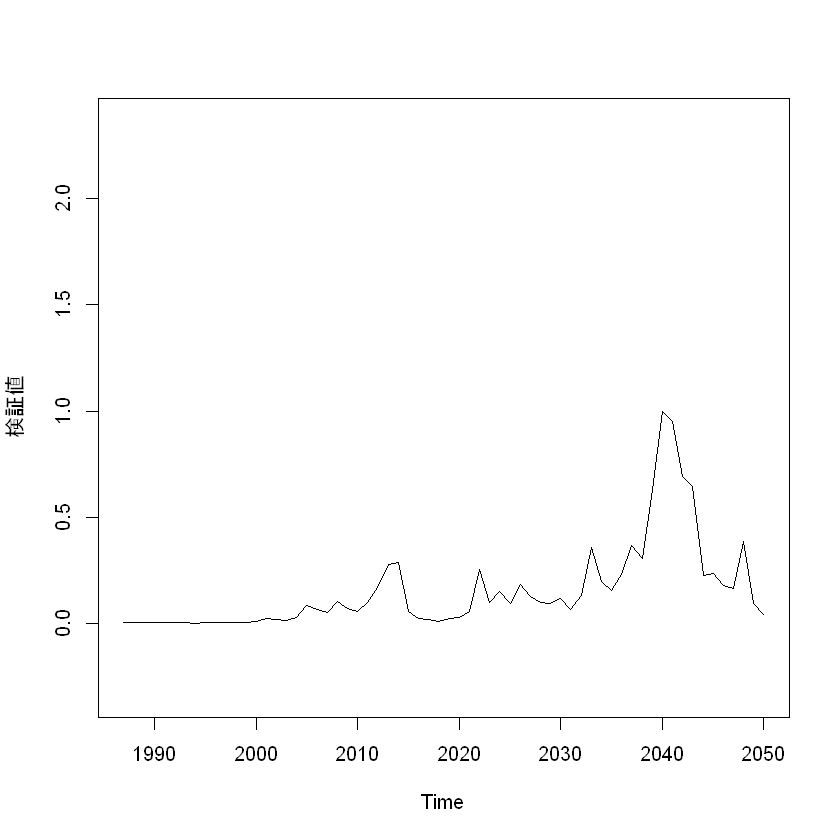

Saving 6.67 x 6.67 in image



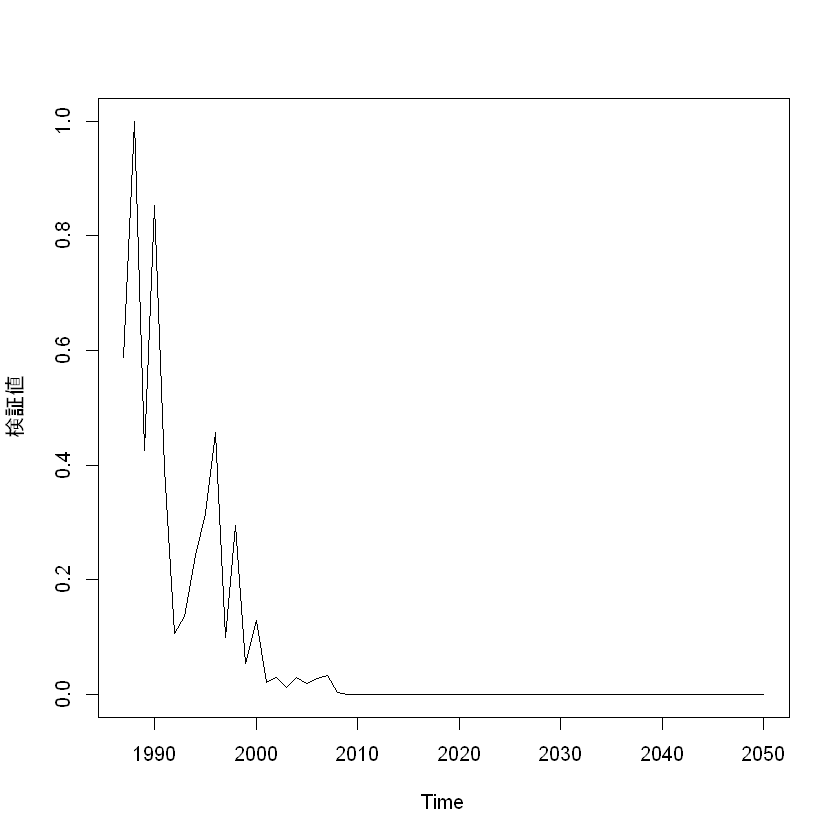

Saving 6.67 x 6.67 in image



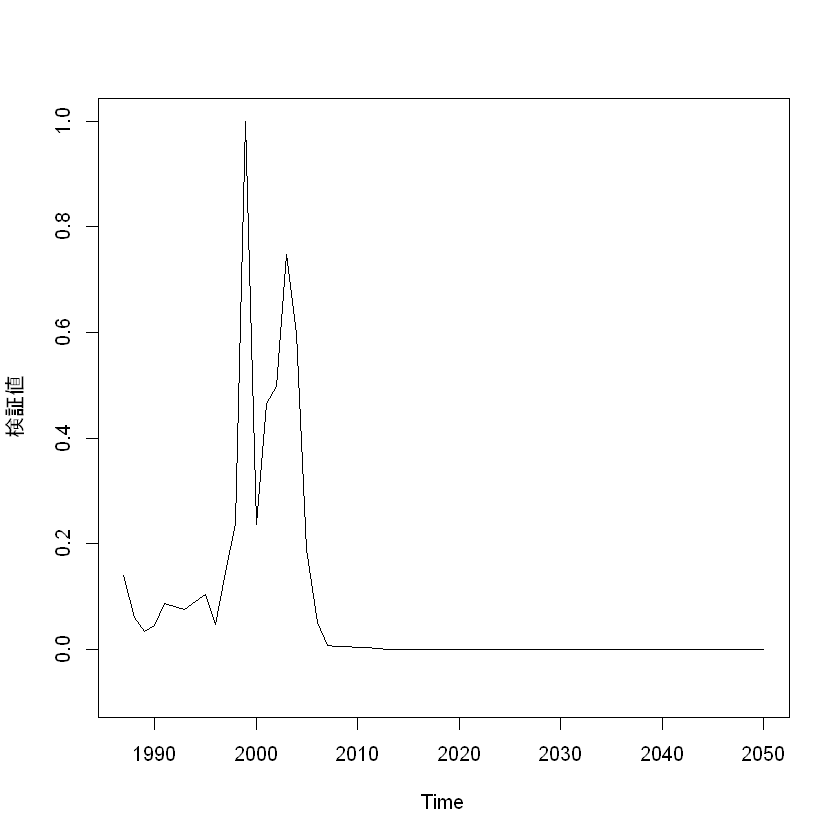

Saving 6.67 x 6.67 in image



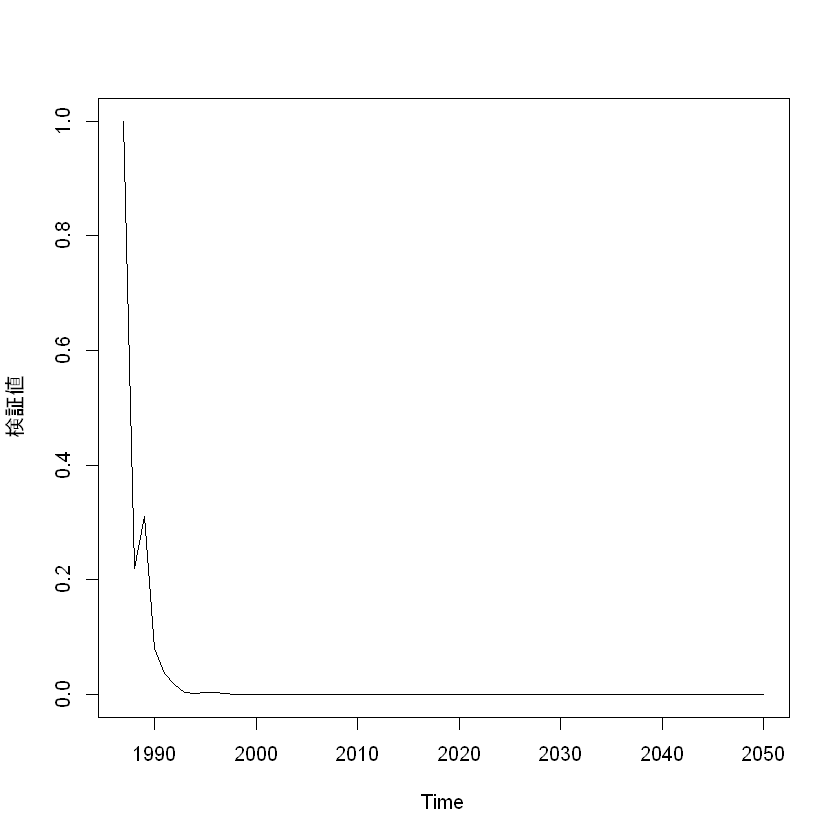

Saving 6.67 x 6.67 in image



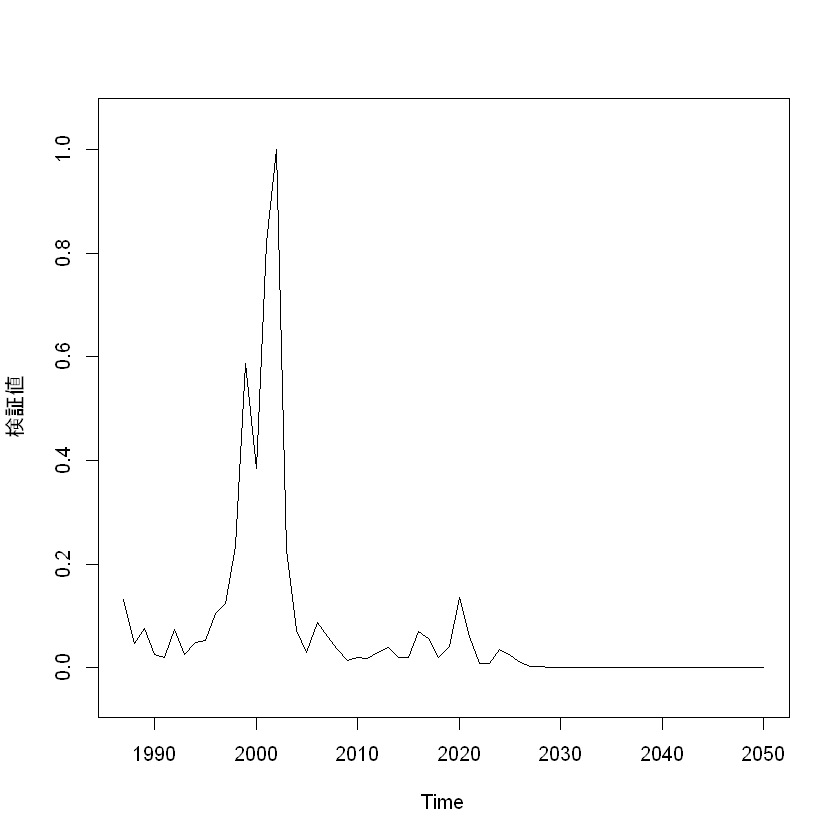

Saving 6.67 x 6.67 in image



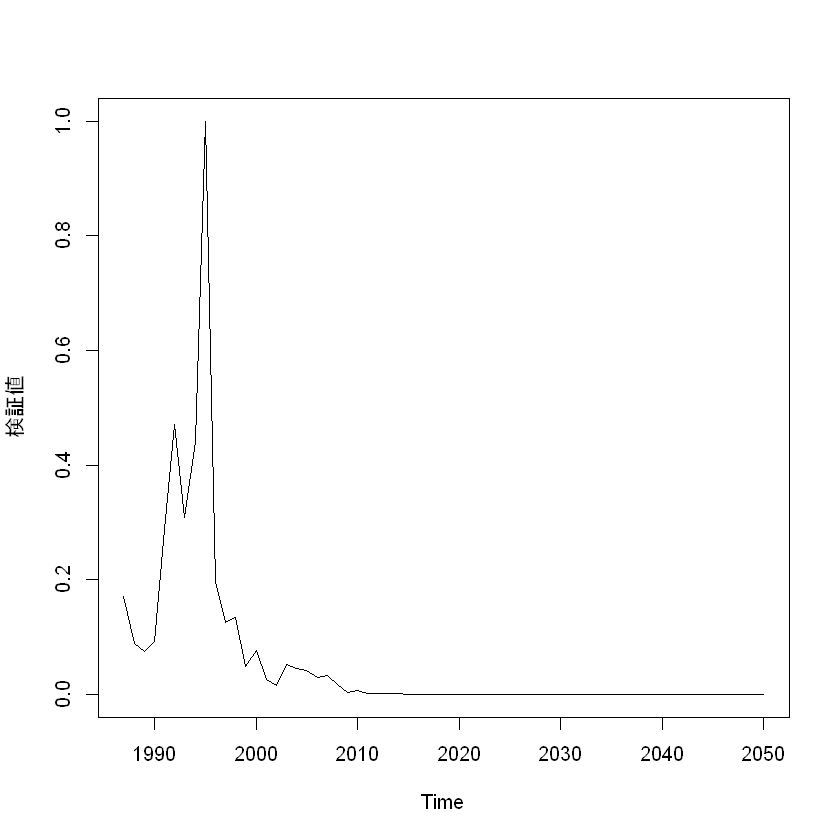

In [26]:
# LSTM(SDE_Y1,  10)
LSTM(SDE_Y2,  10)
ggsave("LSTM_Y2.jpg")
# LSTM(SDE_Y3,  10)
# LSTM(SDE_Y4,  10)
LSTM(SDE_Y5,  10)
ggsave("LSTM_Y5.jpg")
LSTM(SDE_Y6,  10)
ggsave("LSTM_Y6.jpg")
LSTM(SDE_Y7,  10)
ggsave("LSTM_Y7.jpg")
# LSTM(SDE_Y8,  10)
LSTM(SDE_Y9,  10)
ggsave("LSTM_Y9.jpg")
LSTM(SDE_Y10, 10)
ggsave("LSTM_Y10.jpg")
# LSTM(SDE_Y11, 10)

### 結果.csvの出力

In [27]:
fwrite(SPDE, "panel_VAR_SPDE_LSTM_model.csv")

# グラフ描画・出力
1. ローデータの多変量時系列プロット
1. 誤差項調整した多変量時系列プロット
1. 相関行列の可視化による多重共線性の目視確認
1. 幾何ブラウン運動の多変量時系列プロット

## ローデータの多変量時系列プロット

Saving 6.67 x 6.67 in image



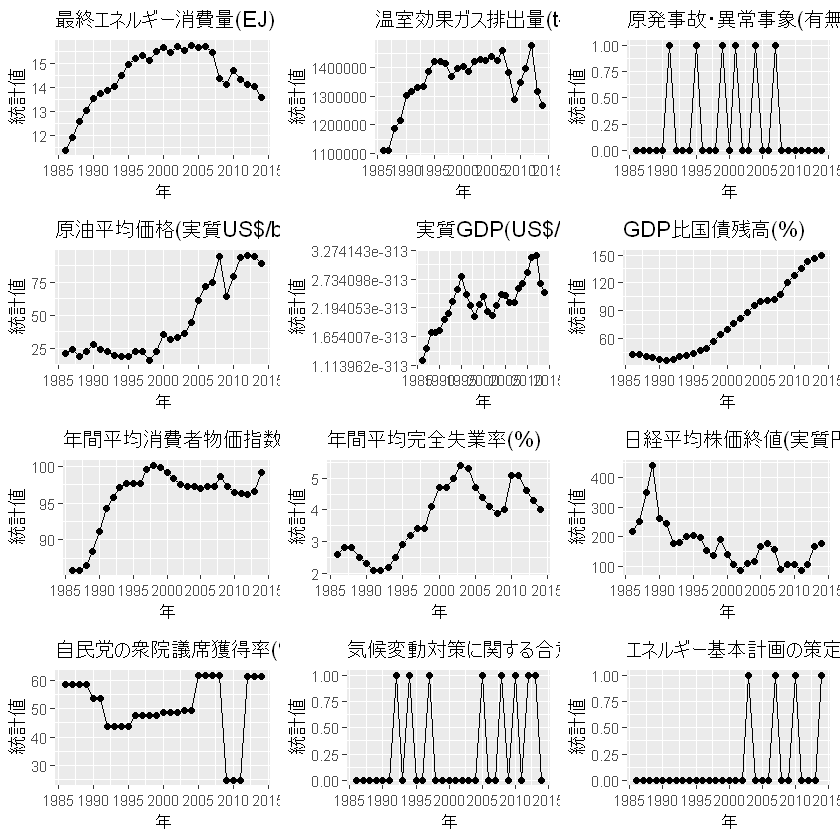

In [28]:
#各グラフの作成
fig_1  <- fig(raw_data, raw_data$Y1, "最終エネルギー消費量(EJ)", "統計値")
fig_2  <- fig(raw_data, raw_data$Y2, "温室効果ガス排出量(t-CO2換算)", "統計値")
fig_3  <- fig(raw_data, raw_data$Y3,  "原発事故・異常事象(有無)", "統計値")
fig_4  <- fig(raw_data, raw_data$Y4, "原油平均価格(実質US$/bbl)", "統計値")
fig_5  <- fig(raw_data, raw_data$Y5, "実質GDP(US$/消費者物価指数: 2015年 = 1)", "統計値")
fig_6  <- fig(raw_data, raw_data$Y6, "GDP比国債残高(%)", "統計値")
fig_7  <- fig(raw_data, raw_data$Y7, "年間平均消費者物価指数(2015年 = 100)", "統計値")
fig_8  <- fig(raw_data, raw_data$Y8, "年間平均完全失業率(%)","統計値")
fig_9  <- fig(raw_data, raw_data$Y9, "日経平均株価終値(実質円)", "統計値")
fig_10 <- fig(raw_data, raw_data$Y10, "自民党の衆院議席獲得率(%)", "統計値")
fig_11 <- fig(raw_data, raw_data$Y11, "気候変動対策に関する合意(有無)", "統計値")
fig_12 <- fig(raw_data, raw_data$id,  "エネルギー基本計画の策定・改正(有無)", "統計値")
#一枚に集約して出力する。
grid.arrange(fig_1, fig_2, fig_3, fig_4, fig_5, fig_6, fig_7, fig_8, fig_9, fig_10, fig_11, fig_12)
ggsave("Multivariate_Time_Series_Plot_raw_data.jpg")

## 誤差項調整した多変量時系列プロット

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



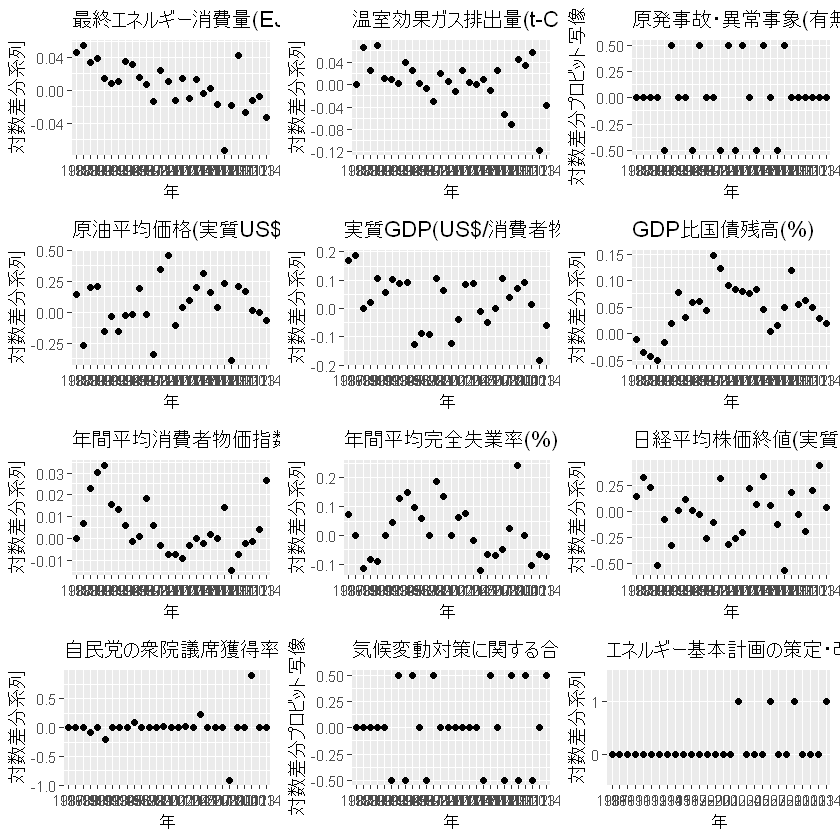

In [29]:
#各グラフの作成
fig_1  <- fig(panel, panel$Y1,  "最終エネルギー消費量(EJ)", "対数差分系列")
fig_2  <- fig(panel, panel$Y2,  "温室効果ガス排出量(t-CO2換算)", "対数差分系列")
fig_3  <- fig(panel, panel$Y3,  "原発事故・異常事象(有無)", "対数差分プロビット写像")
fig_4  <- fig(panel, panel$Y4,  "原油平均価格(実質US$/bbl)", "対数差分系列")
fig_5  <- fig(panel, panel$Y5,  "実質GDP(US$/消費者物価指数: 2015年 = 1)", "対数差分系列")
fig_6  <- fig(panel, panel$Y6,  "GDP比国債残高(%)", "対数差分系列")
fig_7  <- fig(panel, panel$Y7,  "年間平均消費者物価指数(2015年 = 100)","対数差分系列")
fig_8  <- fig(panel, panel$Y8,  "年間平均完全失業率(%)", "対数差分系列")
fig_9  <- fig(panel, panel$Y9,  "日経平均株価終値(実質円)", "対数差分系列")
fig_10 <- fig(panel, panel$Y10, "自民党の衆院議席獲得率(%)", "対数差分系列")
fig_11 <- fig(panel, panel$Y11, "気候変動対策に関する合意(有無)", "対数差分プロビット写像")
fig_12 <- fig(panel, panel$id,  "エネルギー基本計画の策定・改正(有無)", "対数差分系列")
#一枚に集約して出力する。
grid.arrange(fig_1, fig_2, fig_3, fig_4, fig_5, fig_6, fig_7, fig_8, fig_9, fig_10, fig_11, fig_12)
ggsave("Multivariate_Time_Series_Plot_adjusted.jpg")

## 相関行列の可視化による多重共線性の目視確認

Saving 6.67 x 6.67 in image

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



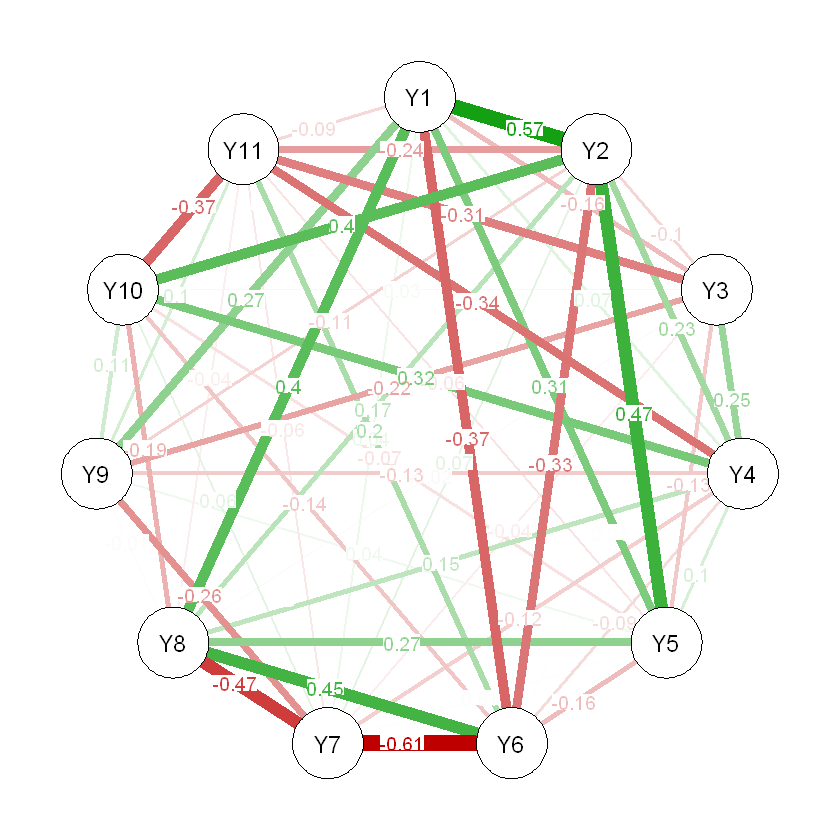

In [30]:
qgraph(cor(relation), edge.labels = TRUE)
ggsave("relation_vector.jpg")

## 幾何ブラウン運動の多変量時系列プロット

Saving 6.67 x 6.67 in image



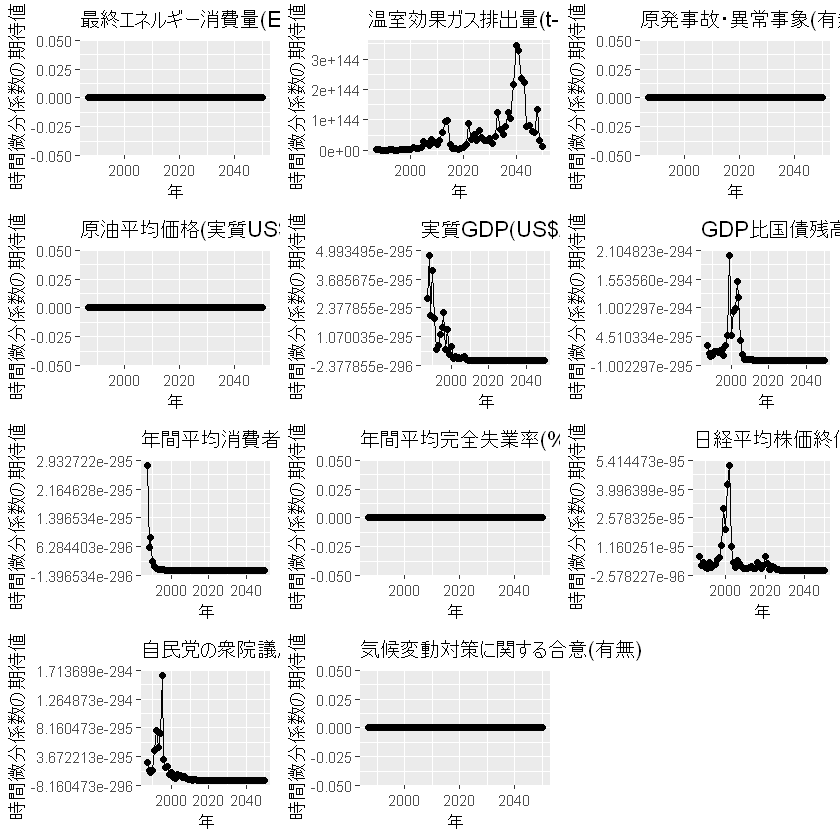

In [31]:
#classをtsからdata.frameに変換し、グラフの規格化を図る。
plot_SDE_Y1  <- SDE_Y1  %>% ts_df
plot_SDE_Y2  <- SDE_Y2  %>% ts_df
plot_SDE_Y3  <- SDE_Y3  %>% ts_df
plot_SDE_Y4  <- SDE_Y4  %>% ts_df
plot_SDE_Y5  <- SDE_Y5  %>% ts_df
plot_SDE_Y6  <- SDE_Y6  %>% ts_df
plot_SDE_Y7  <- SDE_Y7  %>% ts_df
plot_SDE_Y8  <- SDE_Y8  %>% ts_df
plot_SDE_Y9  <- SDE_Y9  %>% ts_df
plot_SDE_Y10 <- SDE_Y10 %>% ts_df
plot_SDE_Y11 <- SDE_Y11 %>% ts_df
#各グラフの作成
fig_1  <- fig(plot_SDE_Y1,plot_SDE_Y1$value,   "最終エネルギー消費量(EJ)","時間微分係数の期待値")
fig_2  <- fig(plot_SDE_Y2,plot_SDE_Y2$value,   "温室効果ガス排出量(t-CO2換算)","時間微分係数の期待値")
fig_3  <- fig(plot_SDE_Y3,plot_SDE_Y3$value,   "原発事故・異常事象(有無)","時間微分係数の期待値")
fig_4  <- fig(plot_SDE_Y4,plot_SDE_Y4$value,   "原油平均価格(実質US$/bbl)","時間微分係数の期待値")
fig_5  <- fig(plot_SDE_Y5,plot_SDE_Y5$value,   "実質GDP(US$/消費者物価指数: 2015年 = 1)","時間微分係数の期待値")
fig_6  <- fig(plot_SDE_Y6,plot_SDE_Y6$value,   "GDP比国債残高(%)","時間微分係数の期待値")
fig_7  <- fig(plot_SDE_Y7,plot_SDE_Y7$value,   "年間平均消費者物価指数(2015年 = 100)","時間微分係数の期待値")
fig_8  <- fig(plot_SDE_Y8,plot_SDE_Y8$value,   "年間平均完全失業率(%)","時間微分係数の期待値")
fig_9  <- fig(plot_SDE_Y9,plot_SDE_Y9$value,   "日経平均株価終値(実質円)","時間微分係数の期待値")
fig_10 <- fig(plot_SDE_Y10,plot_SDE_Y10$value, "自民党の衆院議席獲得率(%)","時間微分係数の期待値")
fig_11 <- fig(plot_SDE_Y11,plot_SDE_Y11$value, "気候変動対策に関する合意(有無)","時間微分係数の期待値")
#一枚に集約して出力する。
grid.arrange(fig_1, fig_2, fig_3, fig_4, fig_5, fig_6, fig_7, fig_8, fig_9, fig_10, fig_11)
ggsave("Multivariate_Time_Series_Plot_GBM.jpg")